# Data Exploration using Scanpy

In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import anndata
DATA_PATH = "/media/gambino/students_workdir/ibp/combined_filtered_counts_13_11.h5"
sc.settings.verbosity = 3
sc.logging.print_versions()
import warnings
warnings.filterwarnings('ignore')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
brotli                      1.0.9
certifi                     2023.11.17
cffi                        1.15.1
charset_normalizer          2.0.4
comm                        0.2.0
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.0
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
get_annotations             NA
h5py                        3.10.0
idna                        3.4
importlib_resources         NA
ipykernel                   6.26.0
ipywidgets                  8.1.1
isodurati

In [3]:
adata = anndata.read(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 178608 × 36601
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def generate_qc_metrics(adata,axes):
    # Add a new column to var indicating whether a gene is mitochondrial
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)
    
    # Display a histogram of total counts
    sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
    axes[0].set_title(f"Total Counts Histogram")

    # Display a violin plot of the percentage of counts coming from mitochondrial genes
    sc.pl.violin(adata, "pct_counts_mt", ax=axes[1], show=False)
    axes[1].set_title(f"Percentage of Counts from Mitochondrial Genes")

    # Display a scatter plot of total counts vs. number of genes, colored by the percentage of counts from mitochondrial genes
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", ax=axes[2], show=False,right_margin=0.01)
    axes[2].set_title(f"Total Counts vs. Number of Genes")


In [5]:
from scipy.stats import median_abs_deviation
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [6]:
import matplotlib.pyplot as plt

def remove_outlier(adata,axes):
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 8
    )
    print(f"Total number of cells: {adata.n_obs}")
    adata_filtered = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    print(f"Number of cells after filtering of low-quality cells: {adata_filtered.n_obs}")
    sc.pl.scatter(adata_filtered, "total_counts", "n_genes_by_counts", color="pct_counts_mt", ax=axes[3], show=False,right_margin=0.1)
    axes[3].set_title(f"Total Counts vs. Number of Genes")
    return adata_filtered

In [7]:
import anndata

import pandas as pd
adata = anndata.read(DATA_PATH)
samples_desc = pd.read_excel("/media/gambino/students_workdir/ibp/Colon_ERC.xlsx")
merged=(samples_desc.set_index("GC code")
             .join([adata.obs["batch"].value_counts()])
             .reset_index()
             .rename(columns={"count": "spot count"}))
merged["condition"]=merged["condition"].str.strip()
merged

GC code       PIN sample name           layer    condition  \
0        GC1004281_E2  PIN_1359      1359_1      Muscularis        young   
1        GC1004282_F2  PIN_1359      1359_2       Submucosa        young   
2        GC1004283_G2  PIN_1359      1359_3  Lamina Propria        young   
3        GC1004284_F4  PIN_1362      1362_1      Muscularis         Aged   
4        GC1004285_G4  PIN_1362      1362_2       Submucosa         Aged   
5        GC1004286_H4  PIN_1362      1362_3  Lamina Propria         Aged   
6   GC108651_SI-GA-C3  PIN_1403      1403_1      Muscularis  Slowtransit   
7   GC108652_SI-GA-D3  PIN_1403      1403_2       Submucosa  Slowtransit   
8   GC108653_SI-GA-E3  PIN_1403      1403_3  Lamina Propria  Slowtransit   
9   GC110299_SI-GA-E8  PIN_1535      1535_1      Muscularis         Aged   
10  GC110300_SI-GA-F8  PIN_1535      1535_2       Submucosa         Aged   
11  GC110301_SI-GA-G8  PIN_1535      1535_3  Lamina Propria         Aged   
12  GC110994_SI-GA-B6  PIN_1600      1600_1      Muscularis  Slowtransit   
13  GC110995_SI-GA-C6  PIN_1600      1600_2       Submucosa  Slowtransit   
14  GC110996_SI-GA-D6  PIN_1600      1600_3  Lamina Propria  Slowtransit   
15  GC111283_SI-GA-D7  PIN_1562      1562_1      Muscularis  Slowtransit   
16  GC111284_SI-GA-E7  PIN_1562      1562_2       Submucosa  Slowtransit   
17  GC111285_SI-GA-F7  PIN_1562      1562_3  Lamina Propria  Slowtransit   
18  GC111488_SI-GA-B4  PIN_1579      1579_1      Muscularis        young   
19  GC111489_SI-GA-C4  PIN_1579      1579_2       Submucosa        young   
20  GC111490_SI-GA-D4  PIN_1579      1579_3  Lamina Propria        young   
21  GC115856_SI-GA-E3  PIN_1659      1659_1      Muscularis         Aged   
22  GC115857_SI-GA-F3  PIN_1659      1659_2       Submucosa         Aged   
23  GC115858_SI-GA-G3  PIN_1659      1659_3  Lamina Propria         Aged   
24  GC115989_SI-GA-H3  PIN_1661      1661_1      Muscularis        young   
25  GC115990_SI-GA-A4  PIN_1661      1661_2       Submucosa        young   
26  GC115991_SI-GA-B4  PIN_1661      1661_3  Lamina Propria        young   

    spot count  
0         6531  
1         5395  
2         7525  
3         6808  
4         6894  
5         6058  
6         3337  
7         8045  
8         6035  
9         5771  
10        6848  
11        8547  
12        8224  
13        2610  
14        2114  
15        3829  
16        6394  
17        3729  
18        7589  
19        6023  
20        7635  
21        8333  
22        3755  
23        5715  
24       10517  
25       14859  
26        9488

Sample: GC1004281_E2
Tissue: Muscularis
Total number of cells: 6531
Number of cells after filtering of low-quality cells: 4290


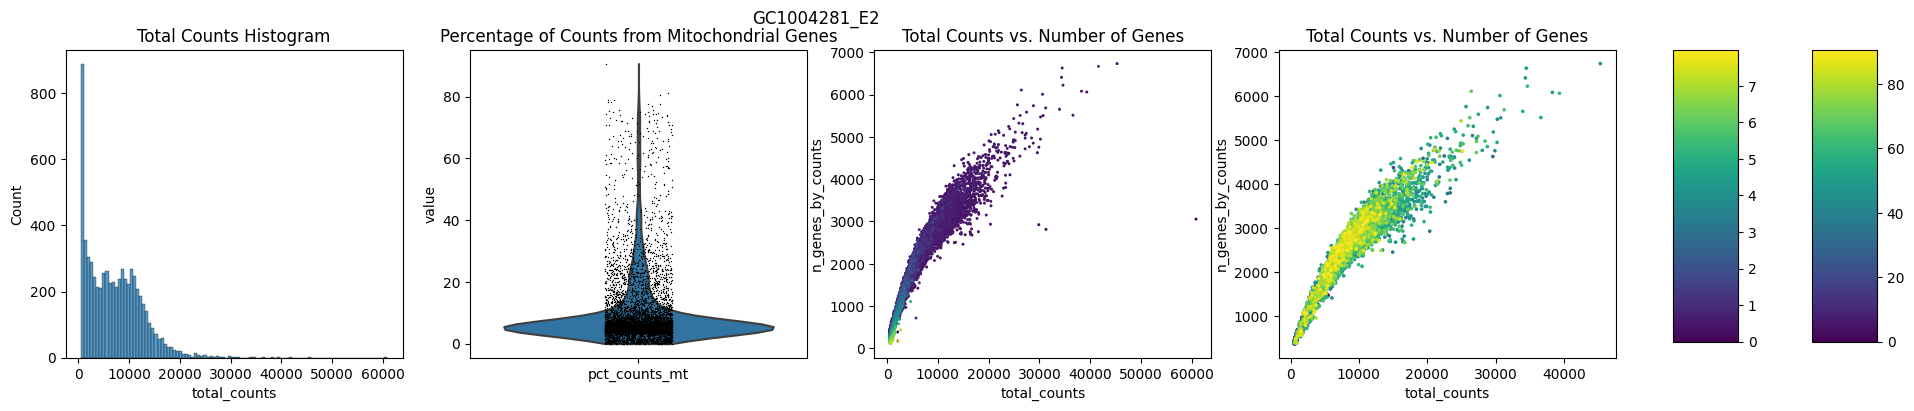

Sample: GC1004282_F2
Tissue: Submucosa
Total number of cells: 5395
Number of cells after filtering of low-quality cells: 3356


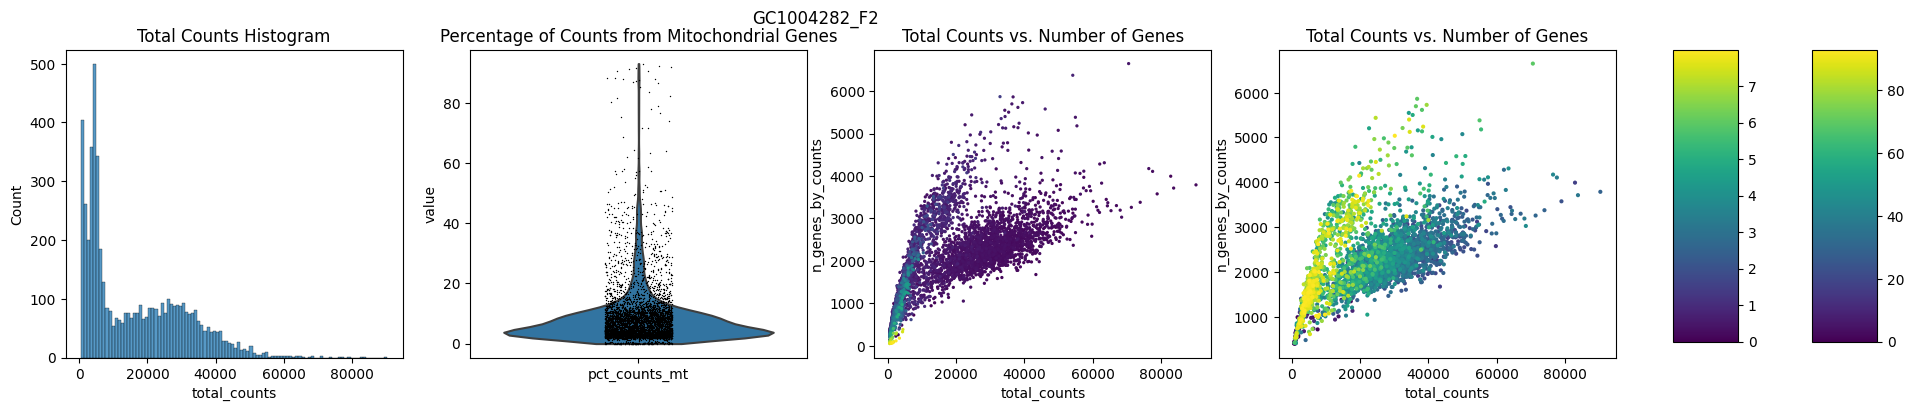

Sample: GC1004283_G2
Tissue: Lamina Propria
Total number of cells: 7525
Number of cells after filtering of low-quality cells: 3359


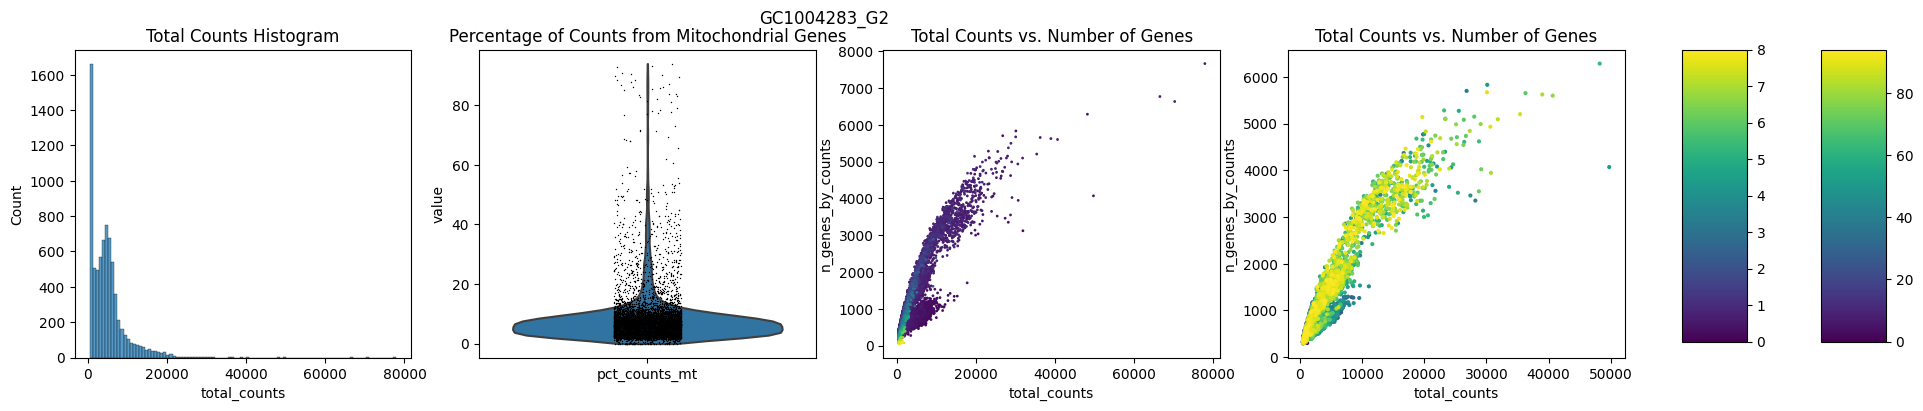

Sample: GC1004284_F4
Tissue: Muscularis
Total number of cells: 6808
Number of cells after filtering of low-quality cells: 4980


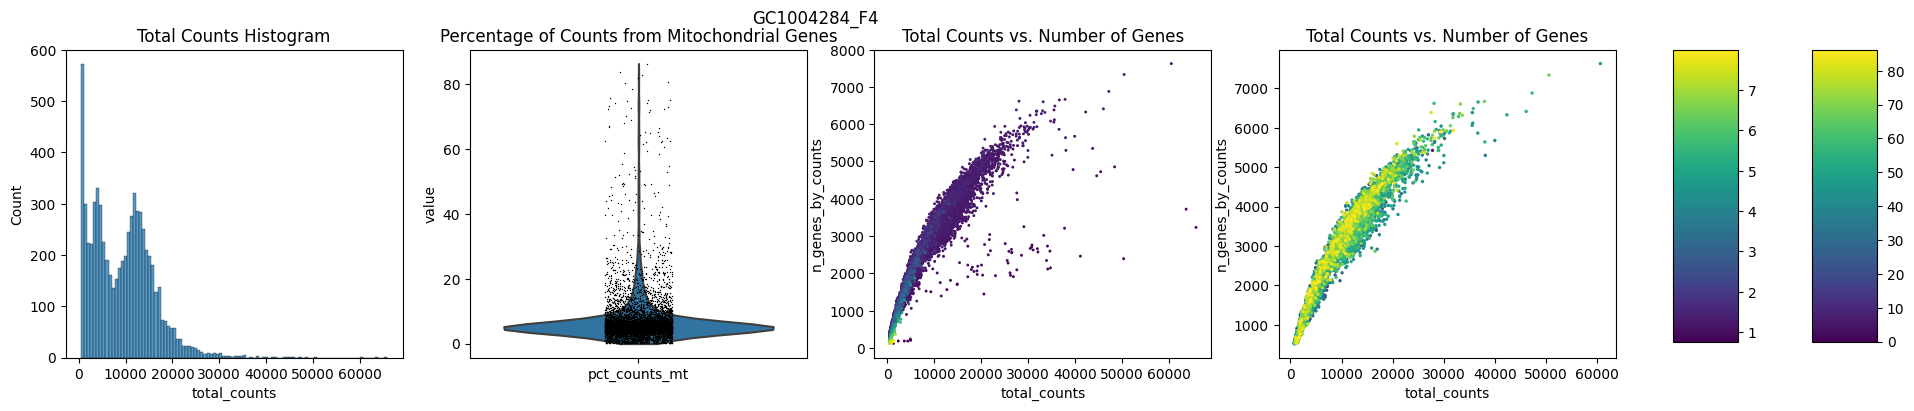

Sample: GC1004285_G4
Tissue: Submucosa
Total number of cells: 6894
Number of cells after filtering of low-quality cells: 5227


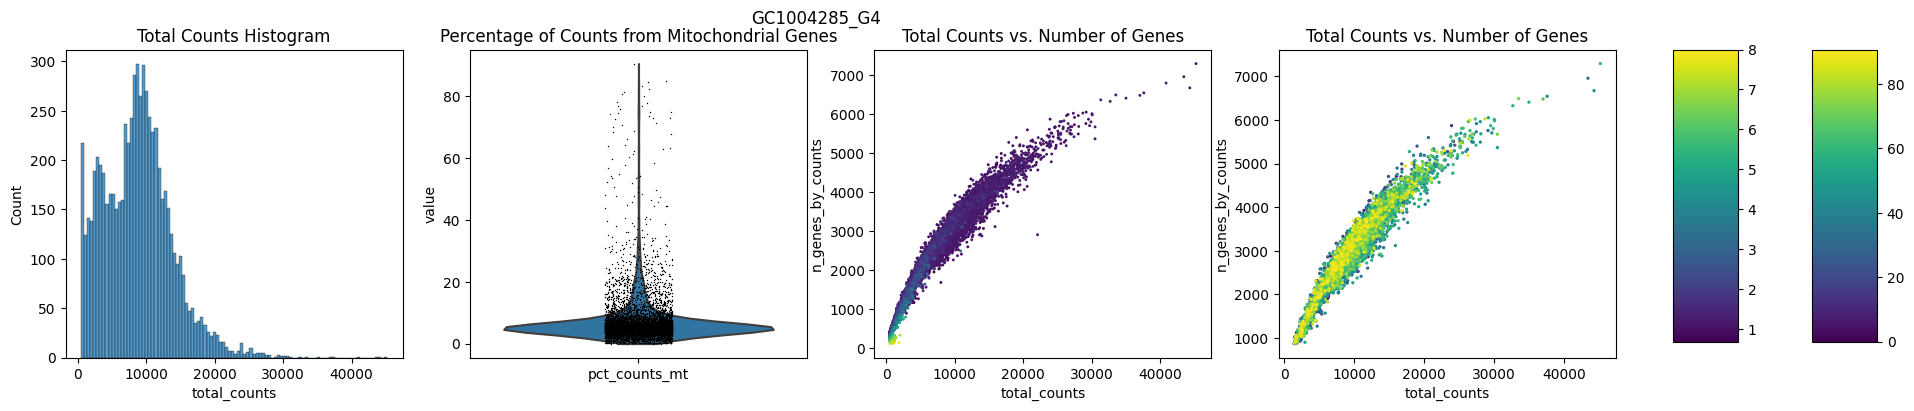

Sample: GC1004286_H4
Tissue: Lamina Propria
Total number of cells: 6058
Number of cells after filtering of low-quality cells: 5091


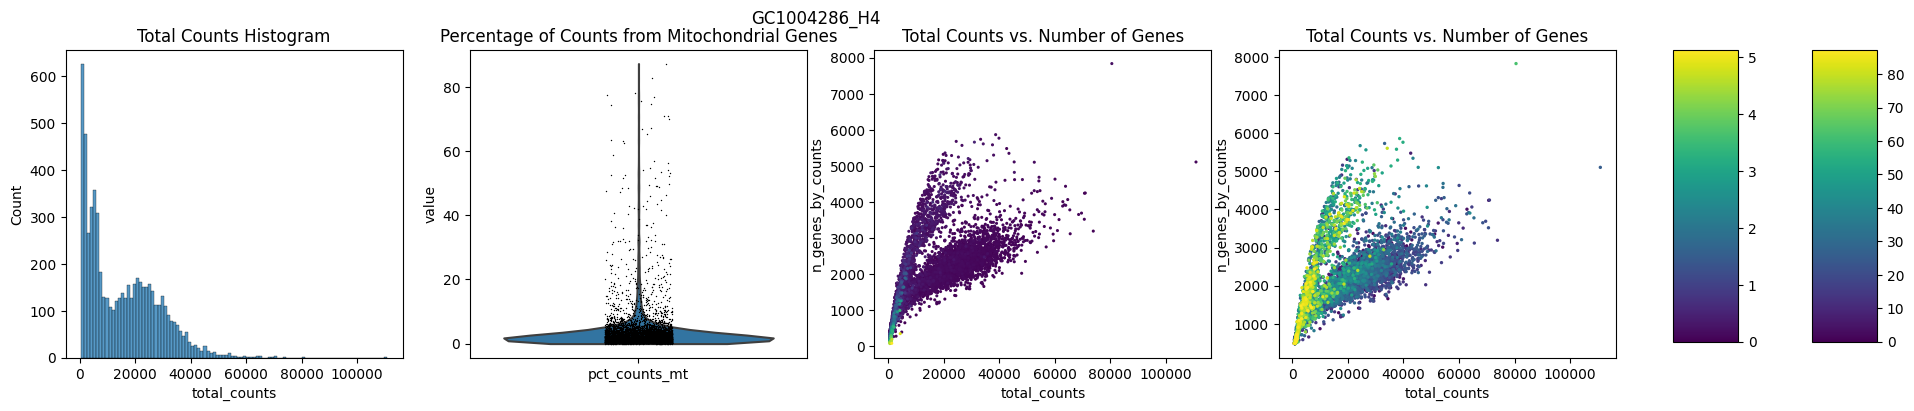

Sample: GC108651_SI-GA-C3
Tissue: Muscularis
Total number of cells: 3337
Number of cells after filtering of low-quality cells: 2597


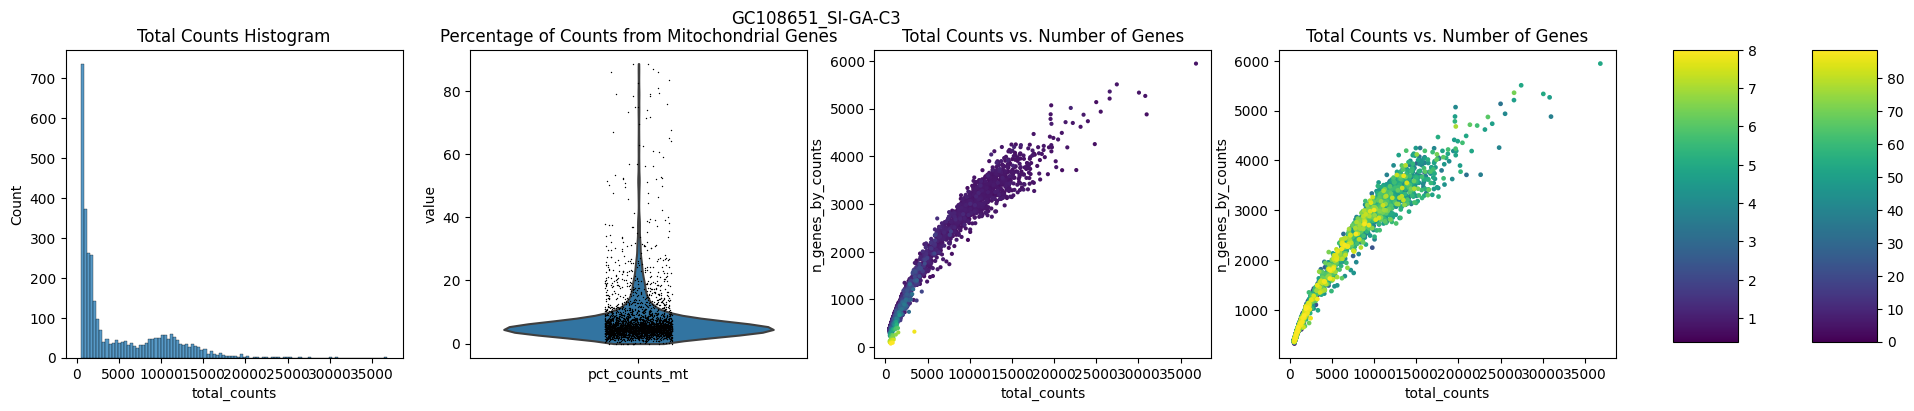

Sample: GC108652_SI-GA-D3
Tissue: Submucosa
Total number of cells: 8045
Number of cells after filtering of low-quality cells: 7070


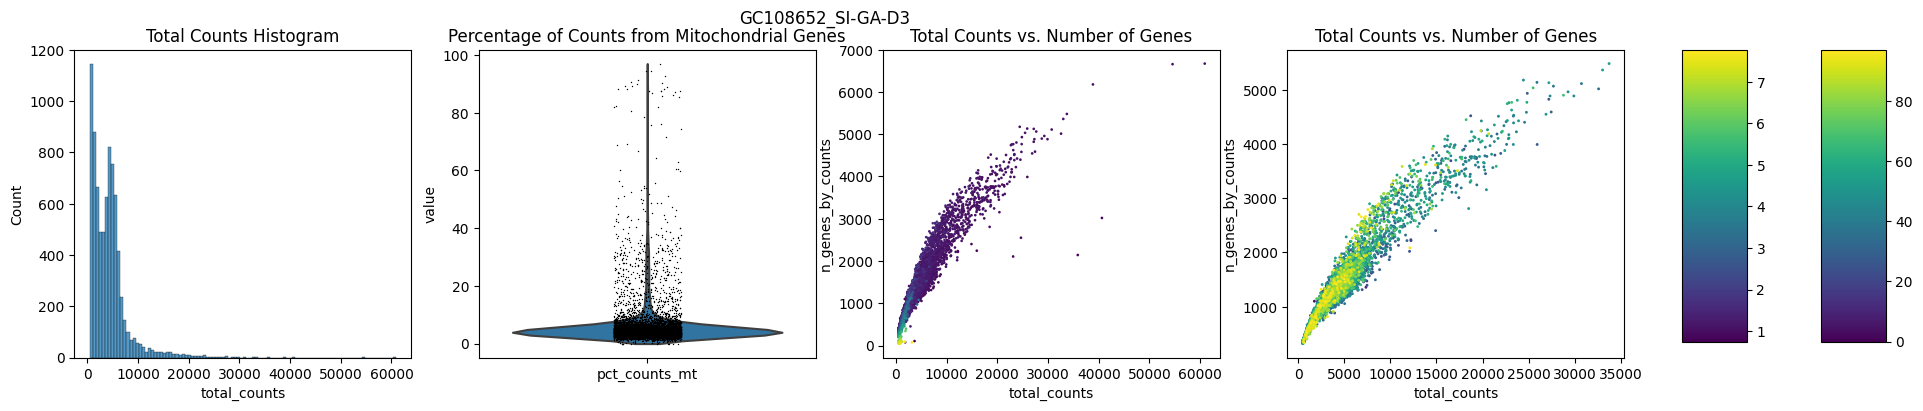

Sample: GC108653_SI-GA-E3
Tissue: Lamina Propria
Total number of cells: 6035
Number of cells after filtering of low-quality cells: 4690


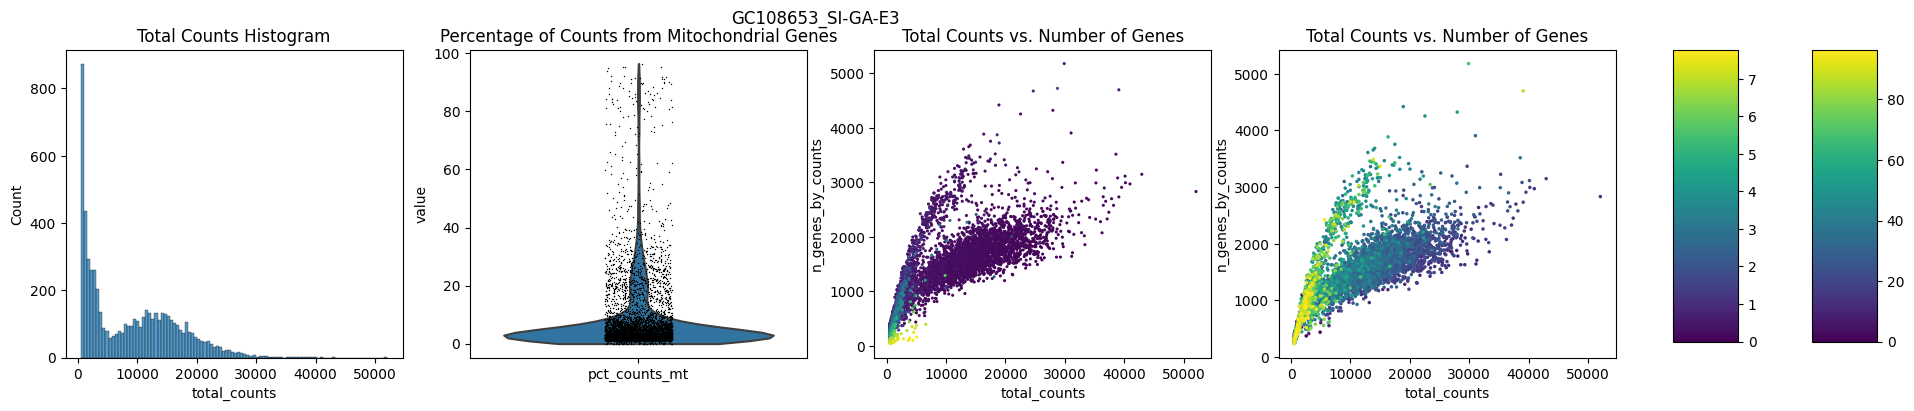

Sample: GC110299_SI-GA-E8
Tissue: Muscularis
Total number of cells: 5771
Number of cells after filtering of low-quality cells: 4036


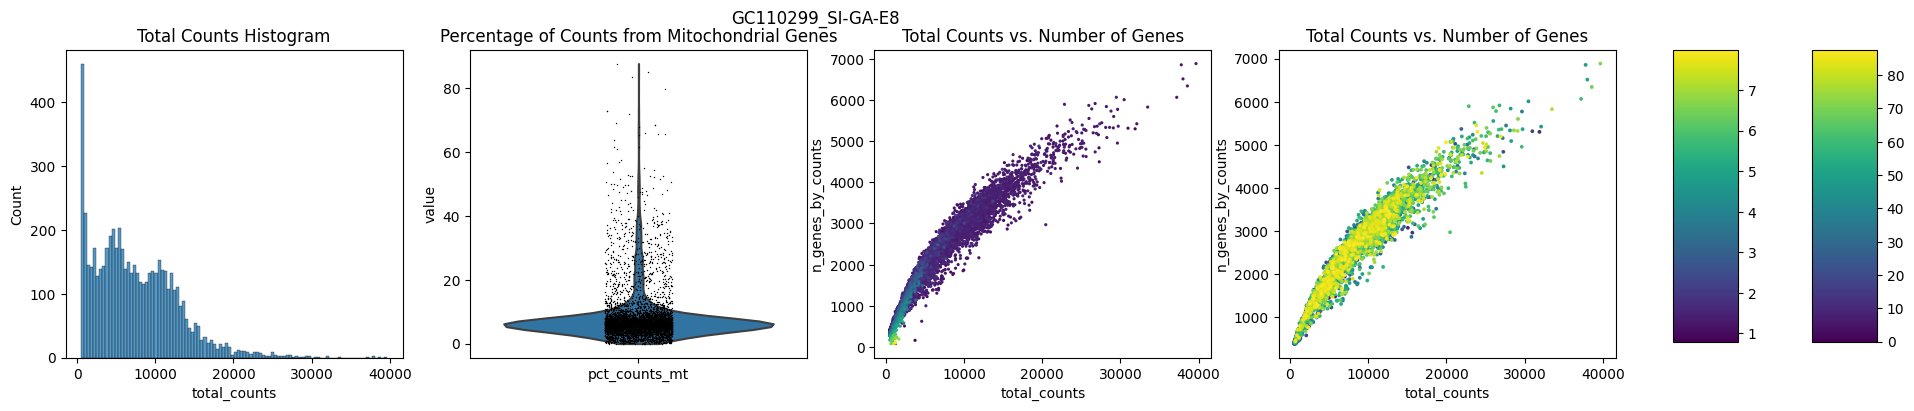

Sample: GC110300_SI-GA-F8
Tissue: Submucosa
Total number of cells: 6848
Number of cells after filtering of low-quality cells: 5445


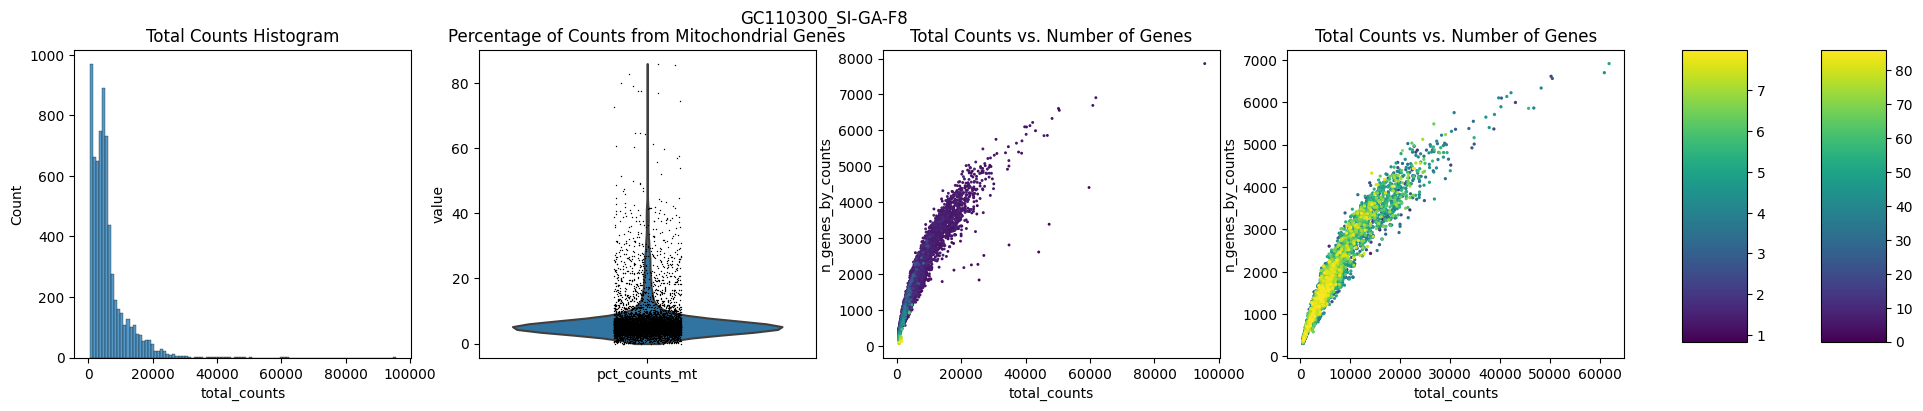

Sample: GC110301_SI-GA-G8
Tissue: Lamina Propria
Total number of cells: 8547
Number of cells after filtering of low-quality cells: 6021


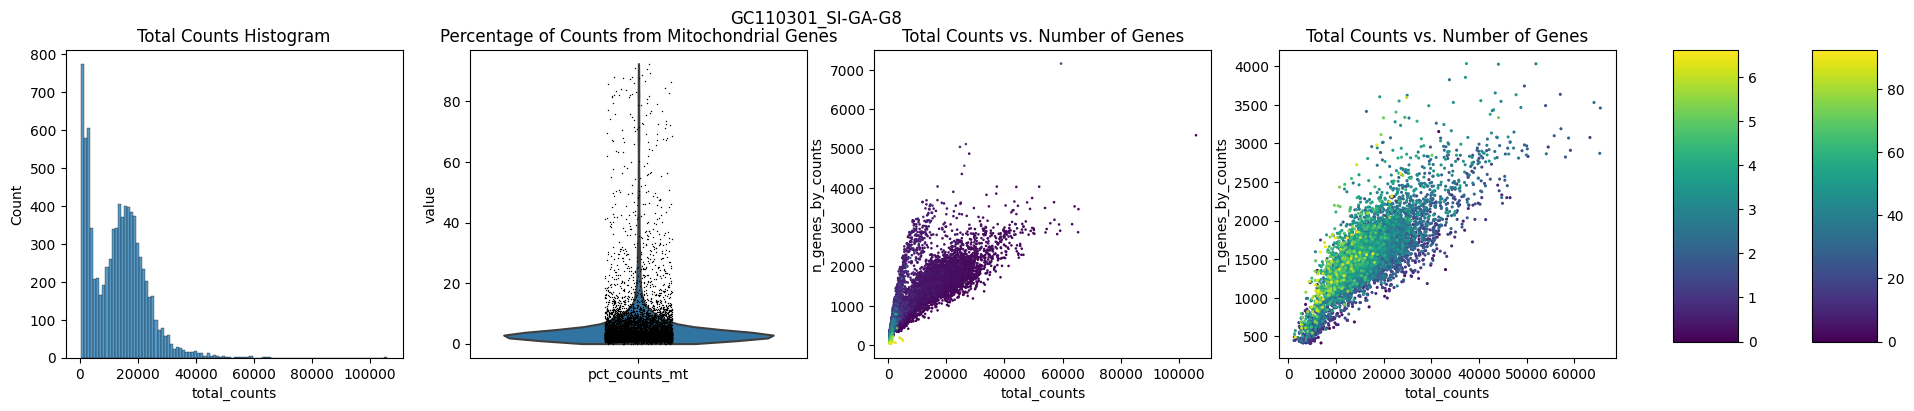

Sample: GC110994_SI-GA-B6
Tissue: Muscularis
Total number of cells: 8224
Number of cells after filtering of low-quality cells: 6933


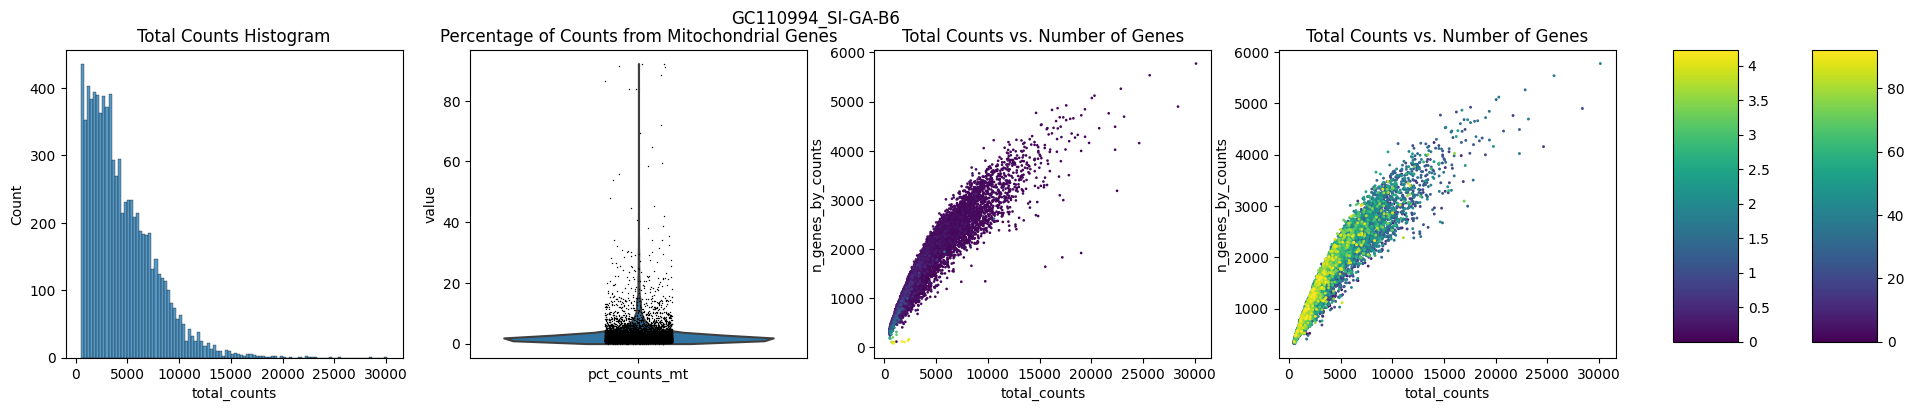

Sample: GC110995_SI-GA-C6
Tissue: Submucosa
Total number of cells: 2610
Number of cells after filtering of low-quality cells: 2338


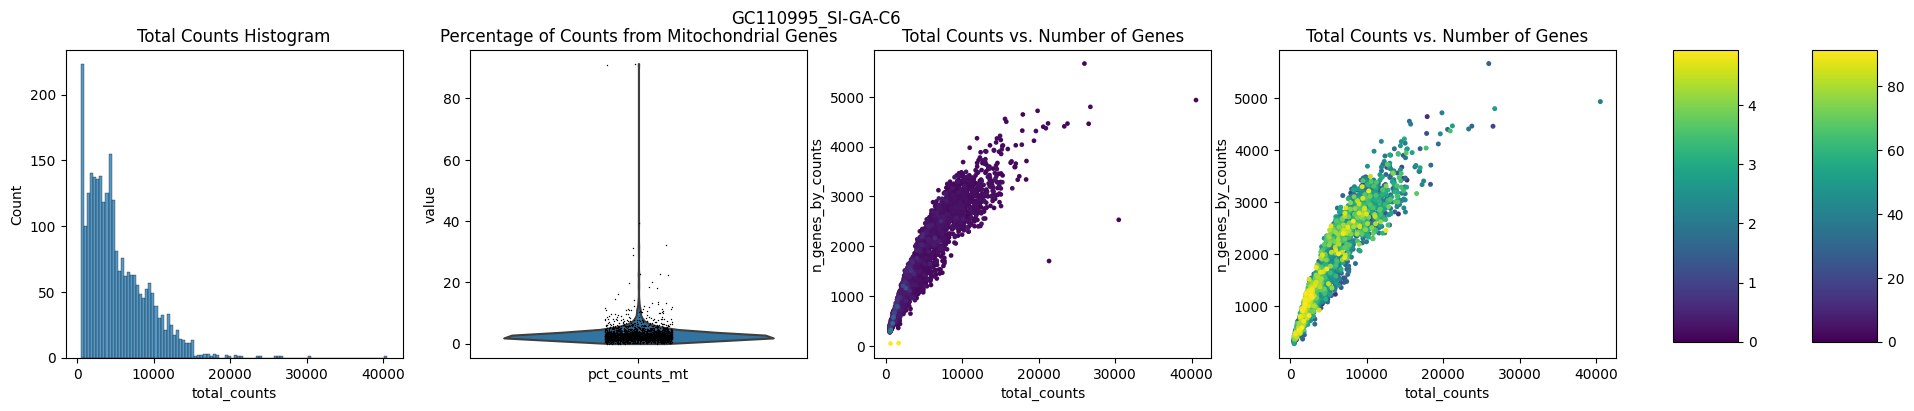

Sample: GC110996_SI-GA-D6
Tissue: Lamina Propria
Total number of cells: 2114
Number of cells after filtering of low-quality cells: 1454


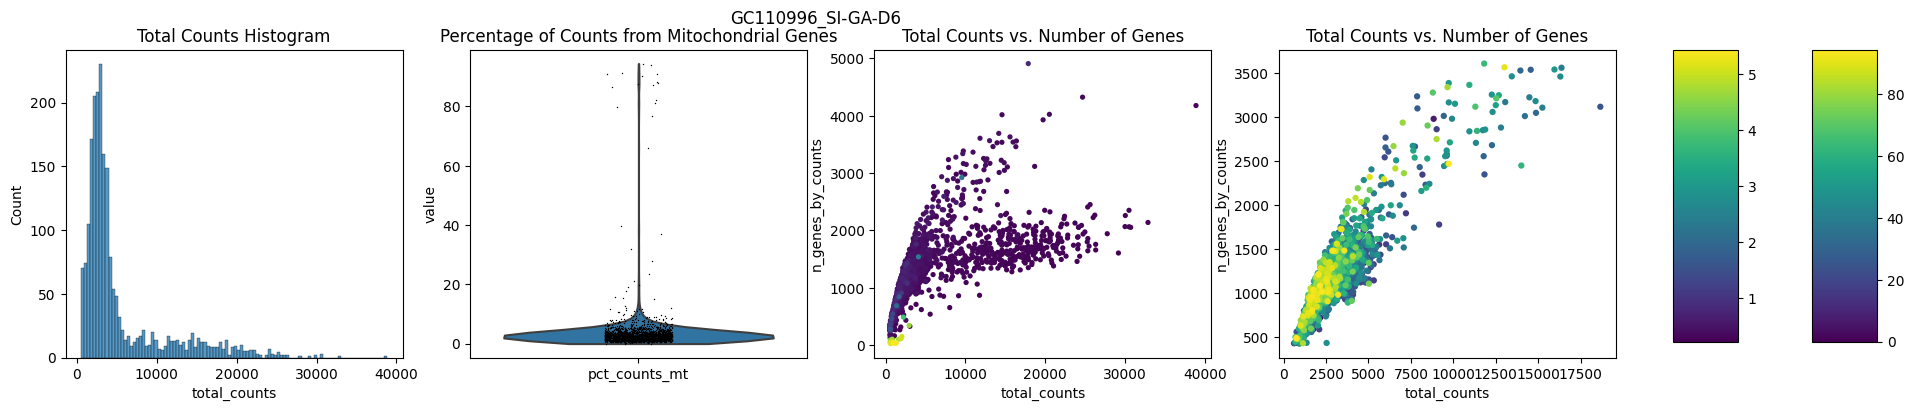

Sample: GC111283_SI-GA-D7
Tissue: Muscularis
Total number of cells: 3829
Number of cells after filtering of low-quality cells: 2486


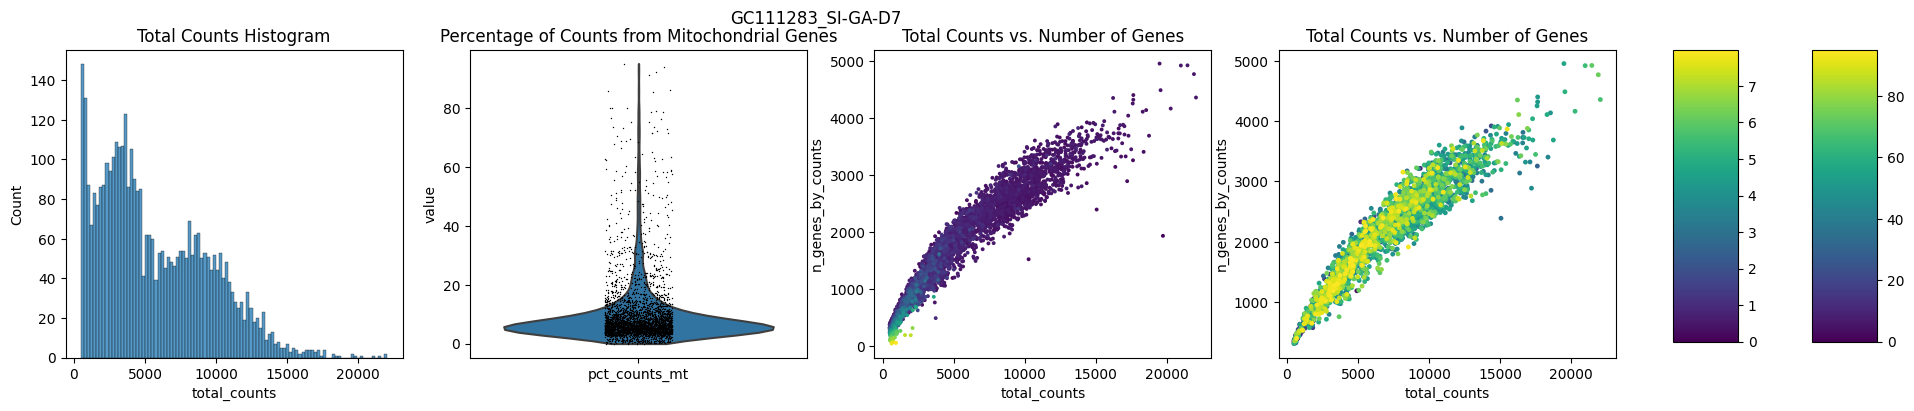

Sample: GC111284_SI-GA-E7
Tissue: Submucosa
Total number of cells: 6394
Number of cells after filtering of low-quality cells: 4930


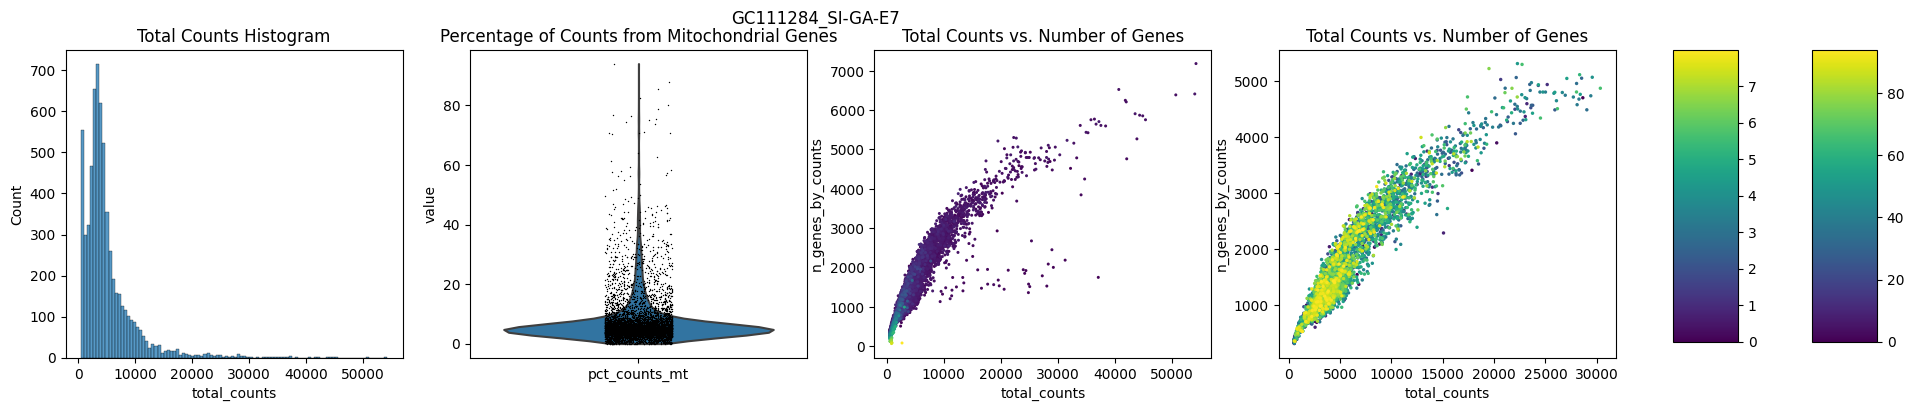

Sample: GC111285_SI-GA-F7
Tissue: Lamina Propria
Total number of cells: 3729
Number of cells after filtering of low-quality cells: 3003


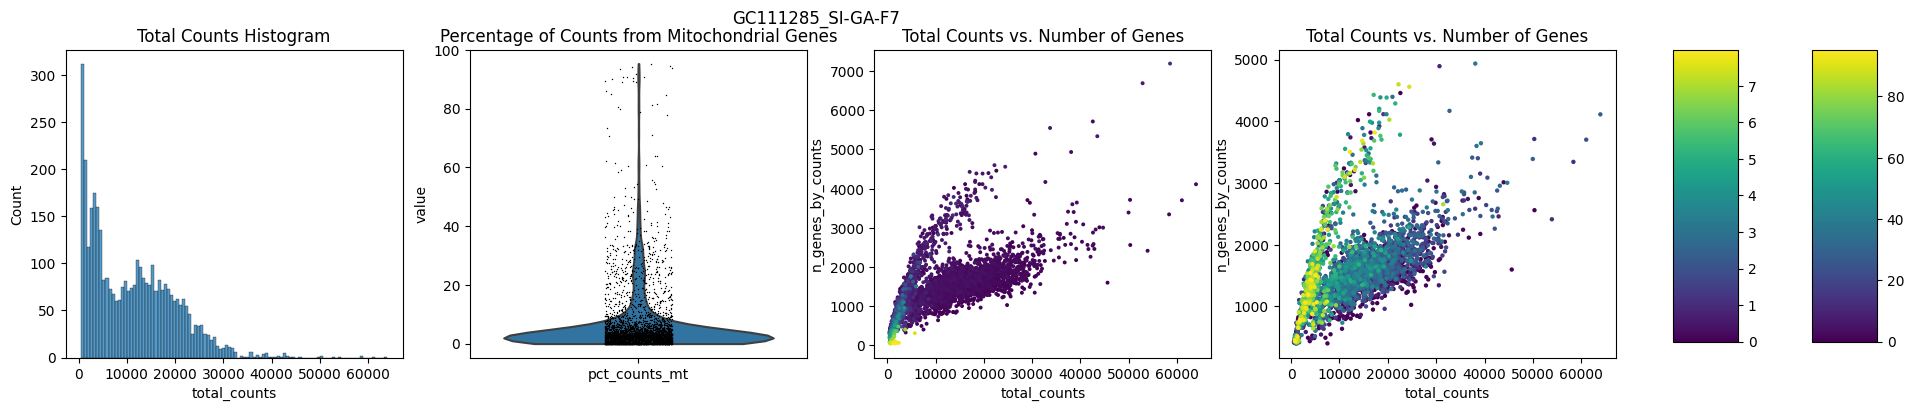

Sample: GC111488_SI-GA-B4
Tissue: Muscularis
Total number of cells: 7589
Number of cells after filtering of low-quality cells: 2080


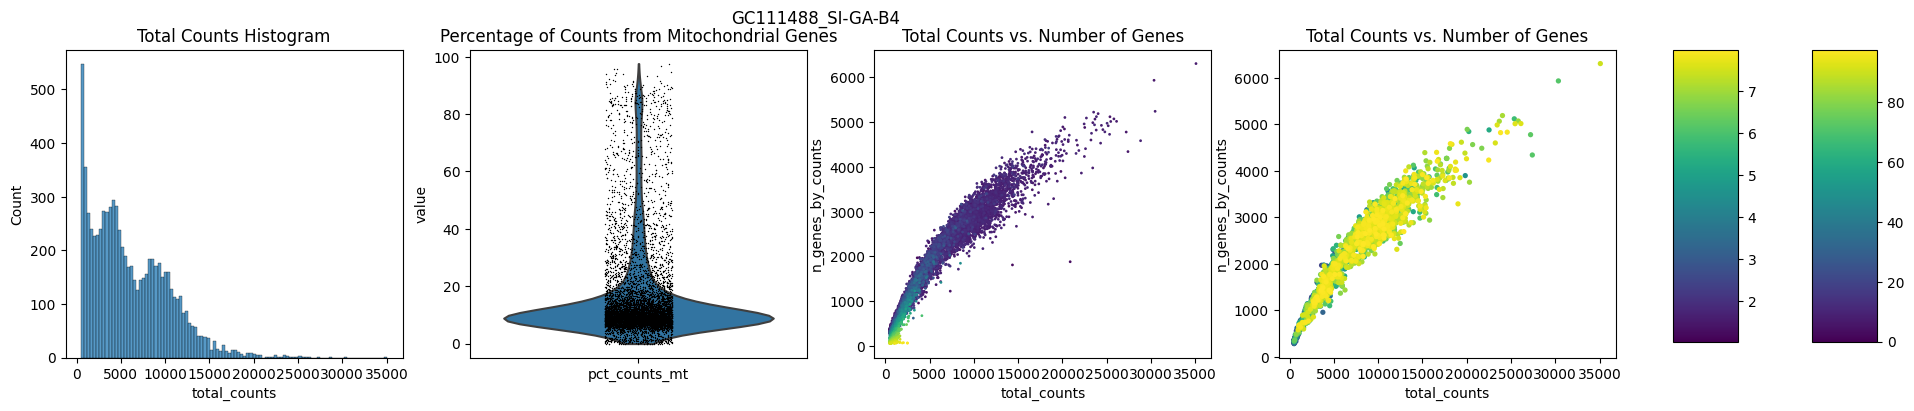

Sample: GC111489_SI-GA-C4
Tissue: Submucosa
Total number of cells: 6023
Number of cells after filtering of low-quality cells: 2147


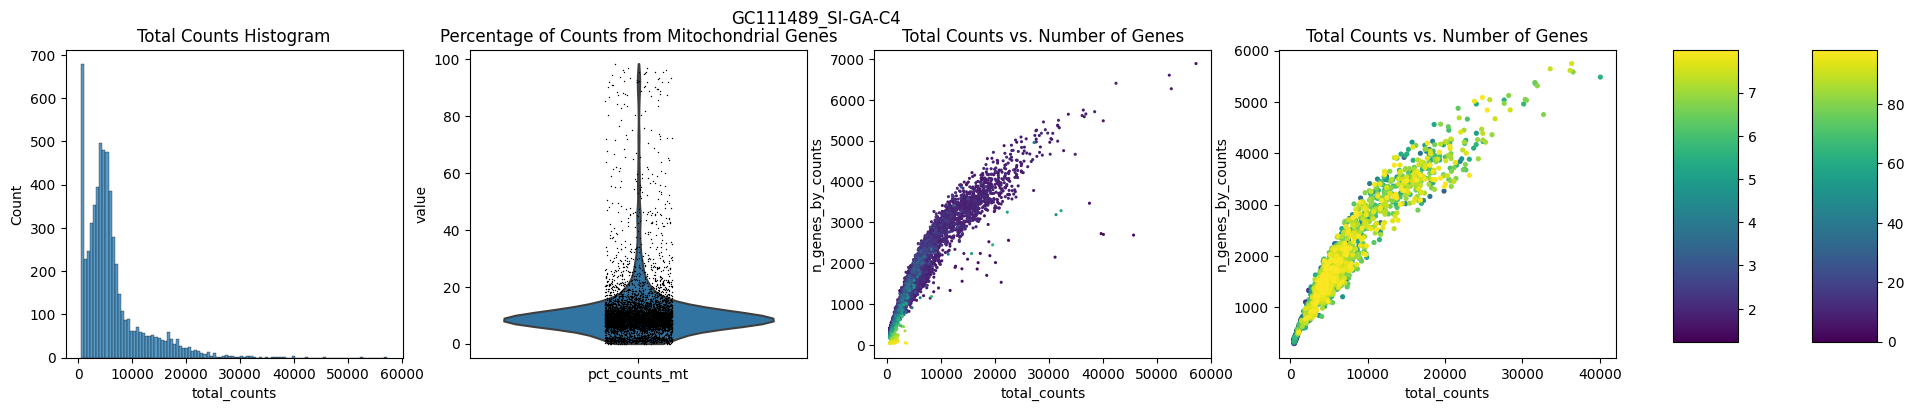

Sample: GC111490_SI-GA-D4
Tissue: Lamina Propria
Total number of cells: 7635
Number of cells after filtering of low-quality cells: 5564


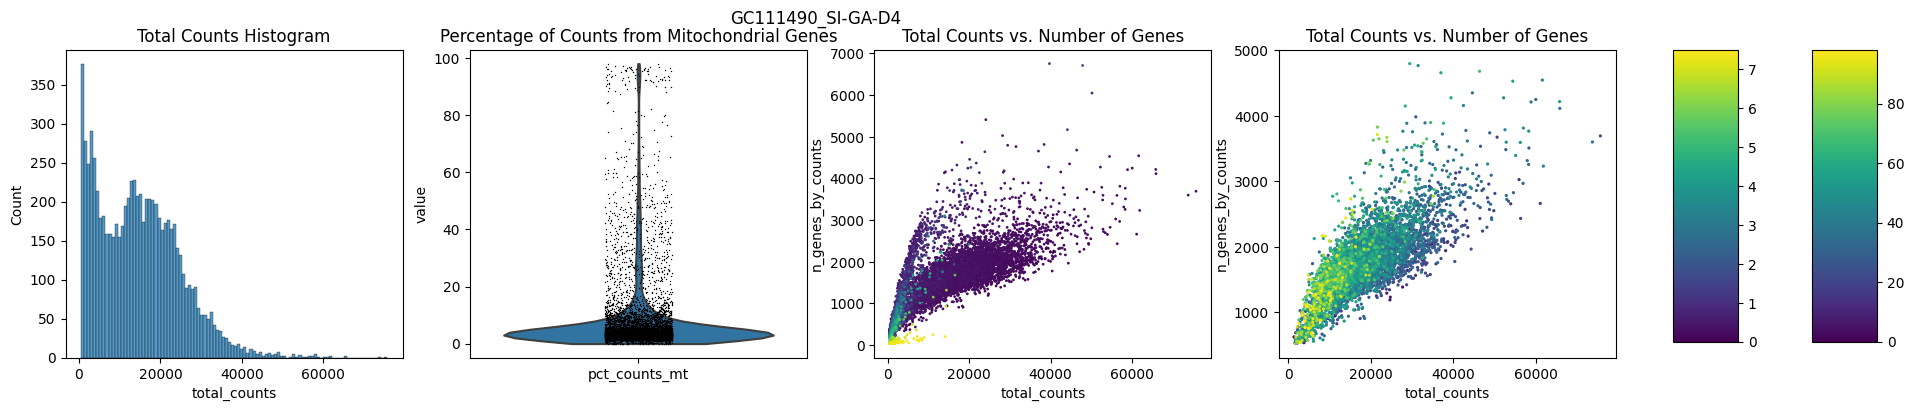

Sample: GC115856_SI-GA-E3
Tissue: Muscularis
Total number of cells: 8333
Number of cells after filtering of low-quality cells: 4595


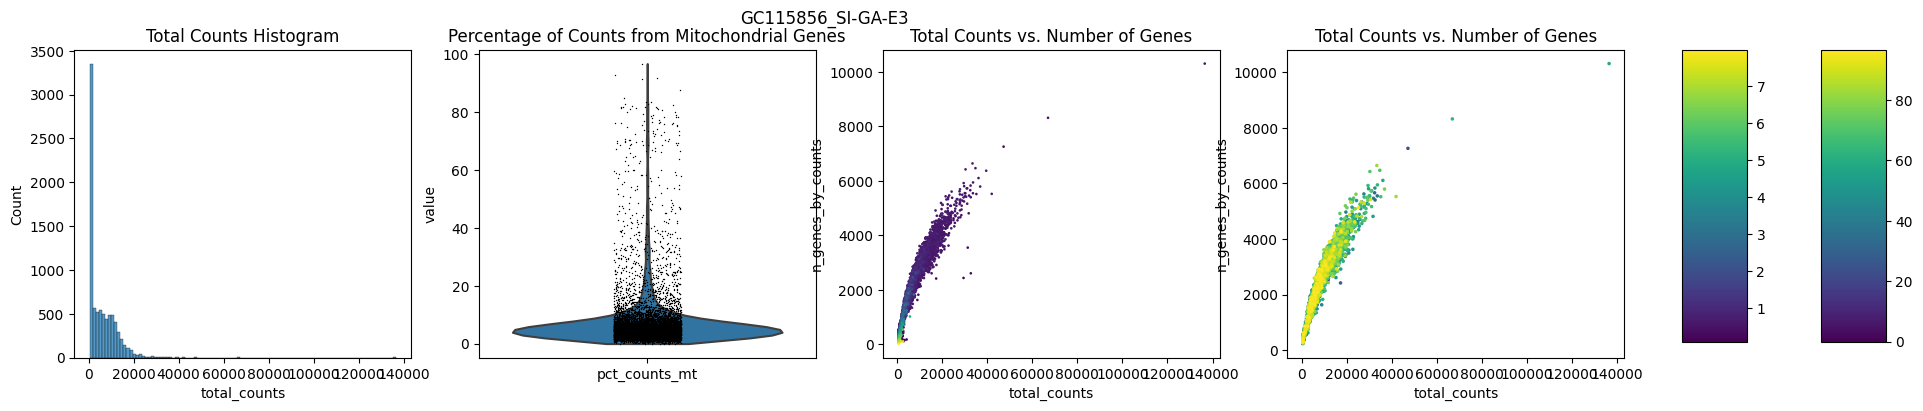

Sample: GC115857_SI-GA-F3
Tissue: Submucosa
Total number of cells: 3755
Number of cells after filtering of low-quality cells: 2877


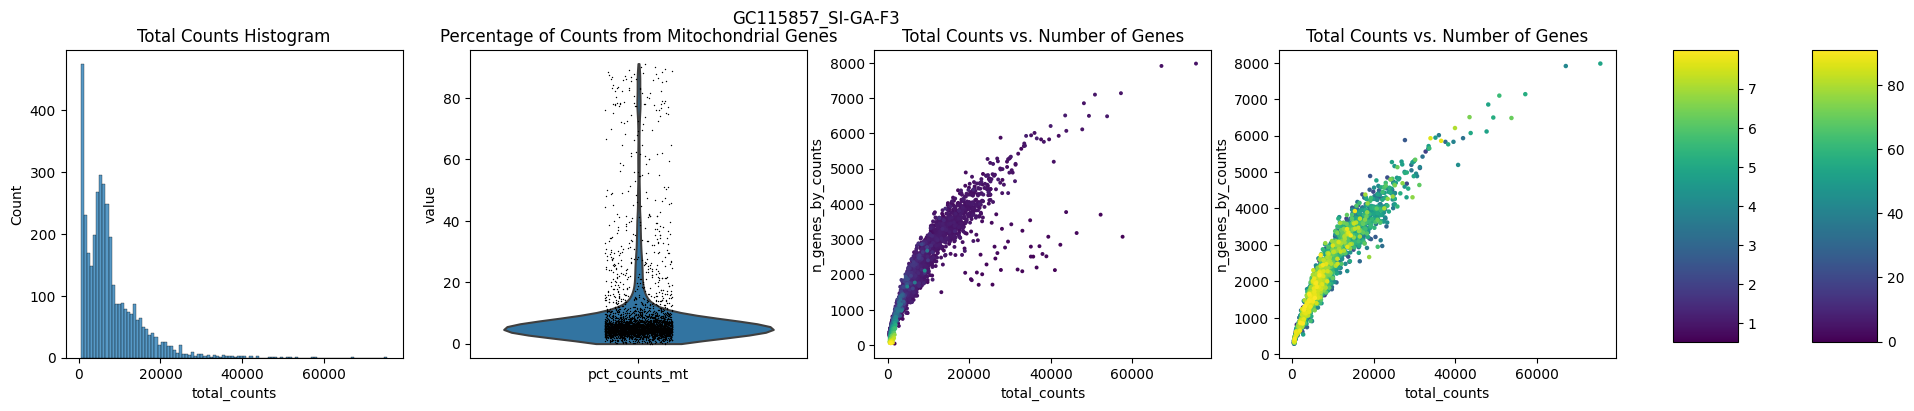

Sample: GC115858_SI-GA-G3
Tissue: Lamina Propria
Total number of cells: 5715
Number of cells after filtering of low-quality cells: 4568


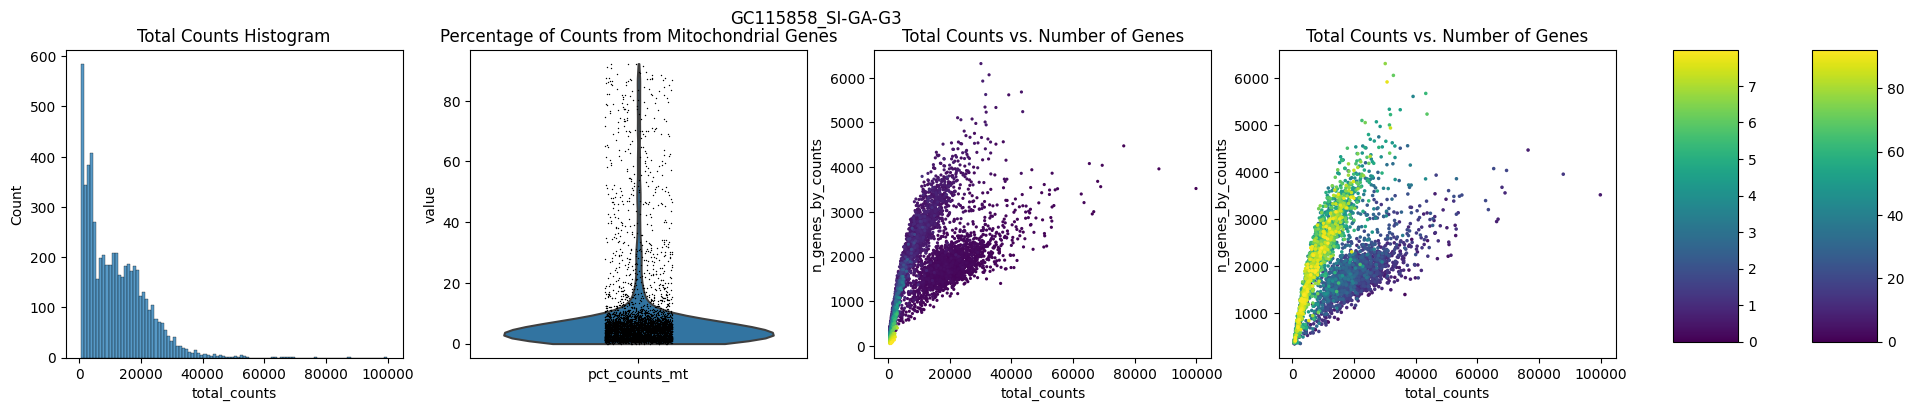

Sample: GC115989_SI-GA-H3
Tissue: Muscularis
Total number of cells: 10517
Number of cells after filtering of low-quality cells: 8933


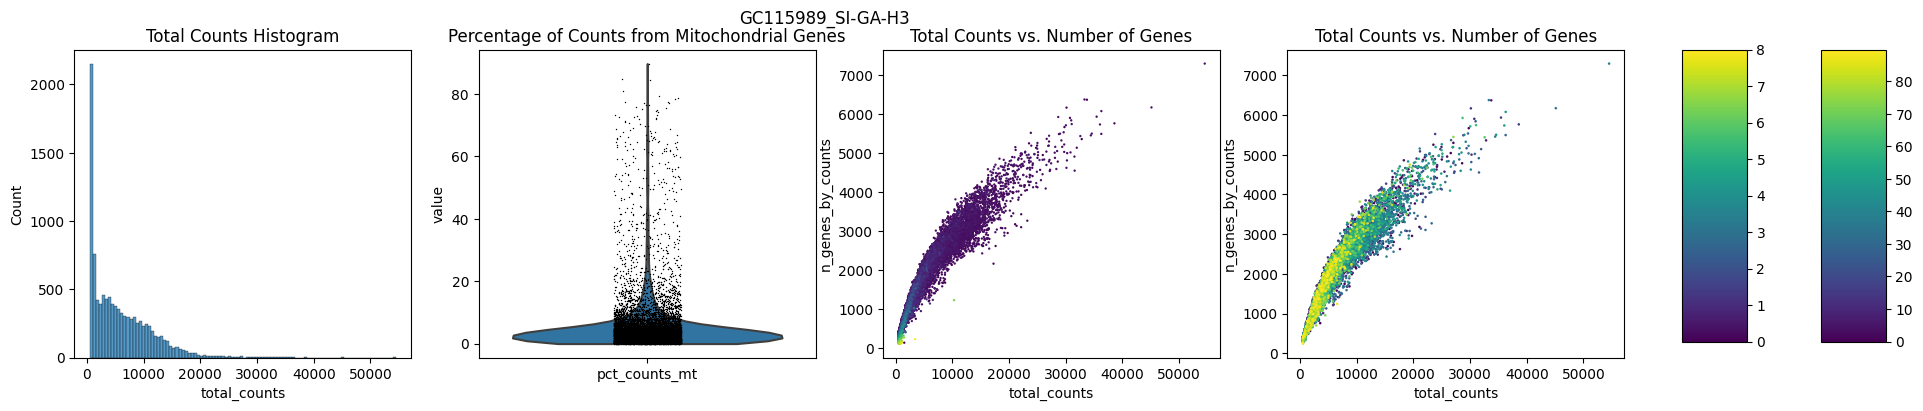

Sample: GC115990_SI-GA-A4
Tissue: Submucosa
Total number of cells: 14859
Number of cells after filtering of low-quality cells: 12745


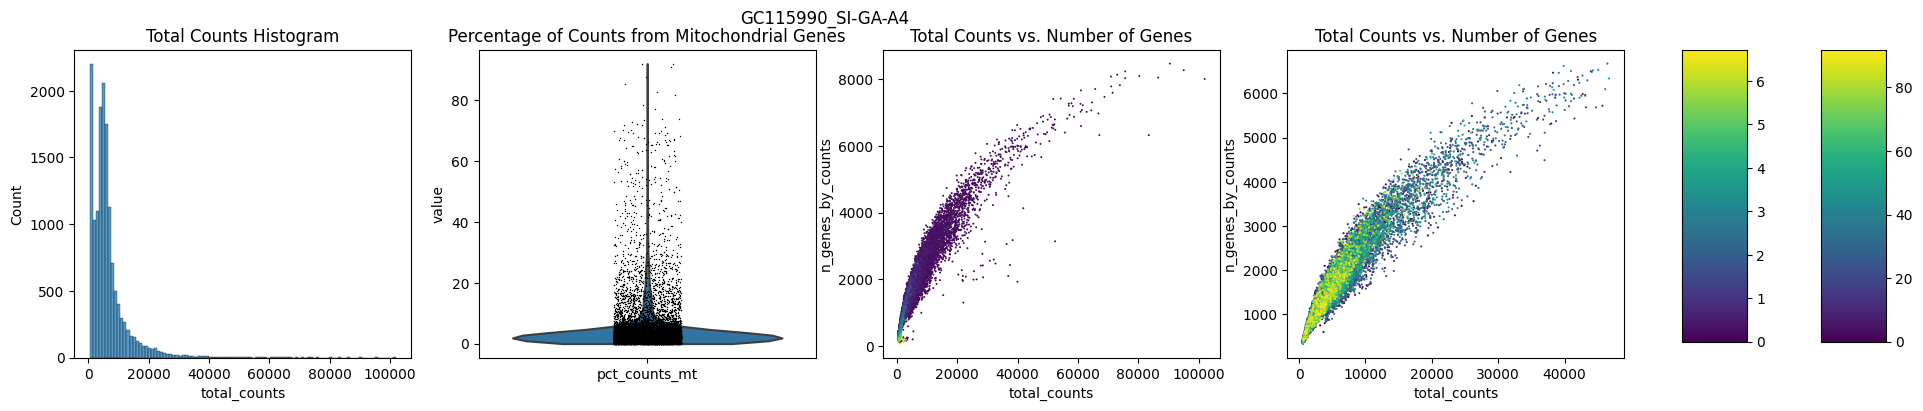

Sample: GC115991_SI-GA-B4
Tissue: Lamina Propria
Total number of cells: 9488
Number of cells after filtering of low-quality cells: 5990


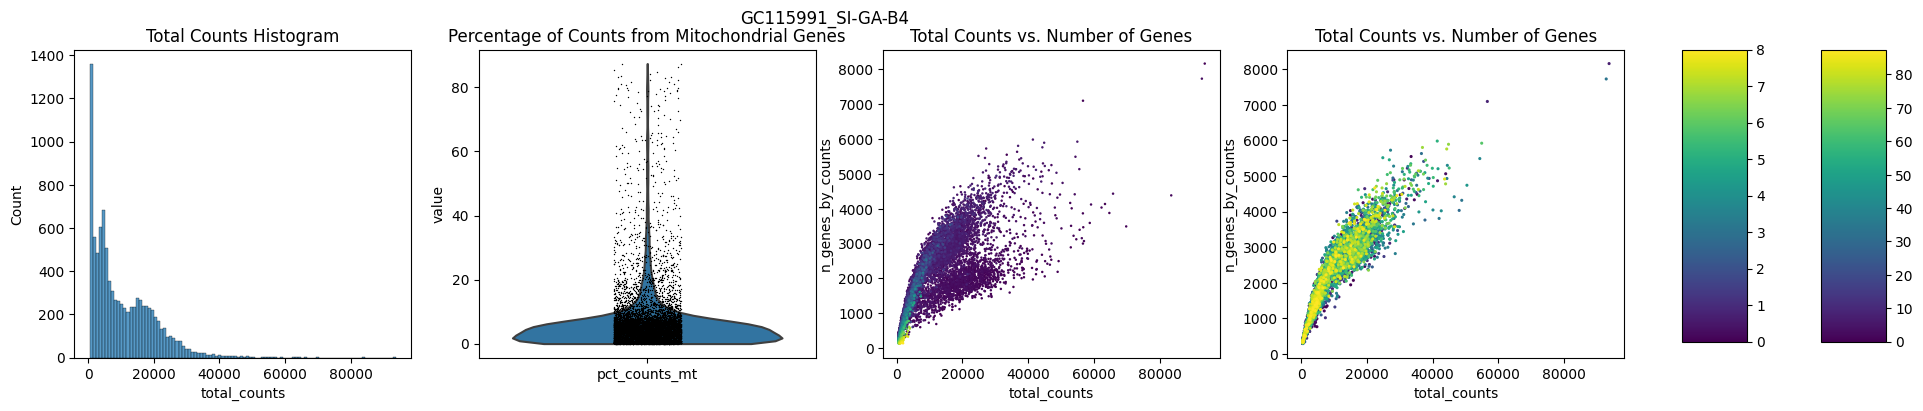

In [8]:
samples=adata.obs["batch"].unique()
qc_adatas=[]
qc_adatas_dict={}
for sample in samples:
    print(f"Sample: {sample}")
    print(f"Tissue: {merged.loc[merged['GC code']==sample,'layer'].values[0]}")
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    subset=adata[adata.obs["batch"] ==sample].copy()
    qc_adatas_dict[sample]=[len(subset)]
    generate_qc_metrics(subset,axes)
    subset=remove_outlier(subset,axes)
    qc_adatas_dict[sample].append(len(subset))
    qc_adatas.append(subset)
    fig.suptitle(sample)
    plt.show()

In [9]:
import anndata as ann
combined = ann.concat(qc_adatas, merge="same")
print("Before filtering: ",adata.shape[0])
print("After filtering: ",combined.shape[0])
combined.obs_names_make_unique()
qc_adatas_dict["Total"]=[adata.shape[0]]
qc_adatas_dict["Total"].append(combined.shape[0])

Before filtering:  178608
After filtering:  126805


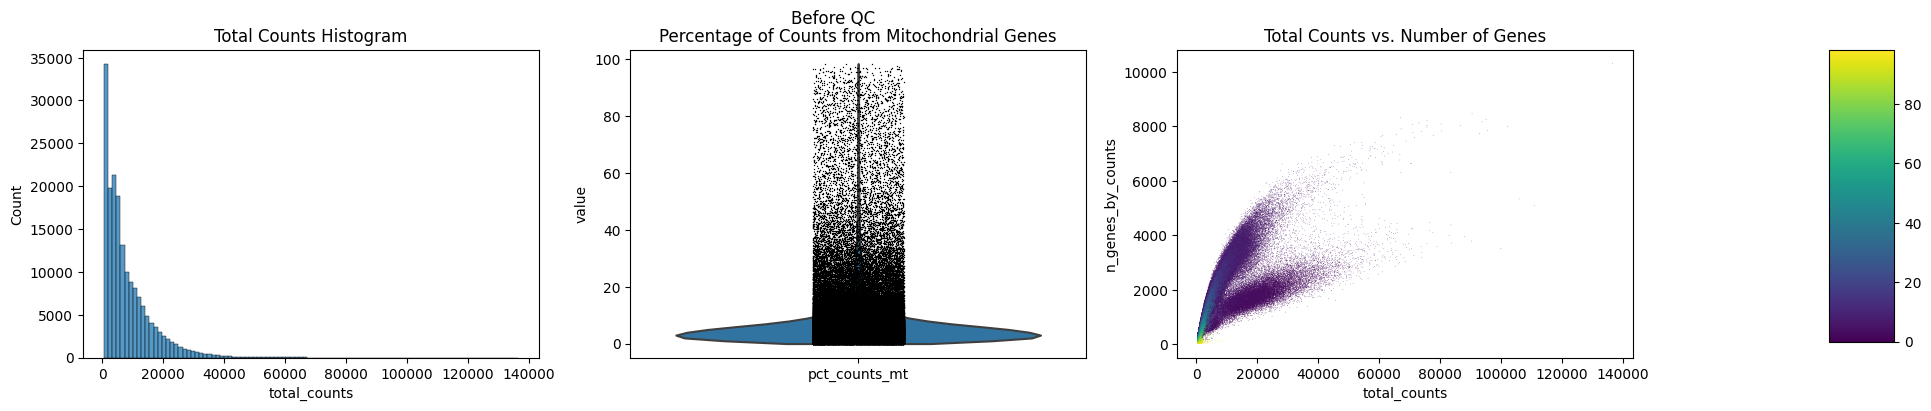

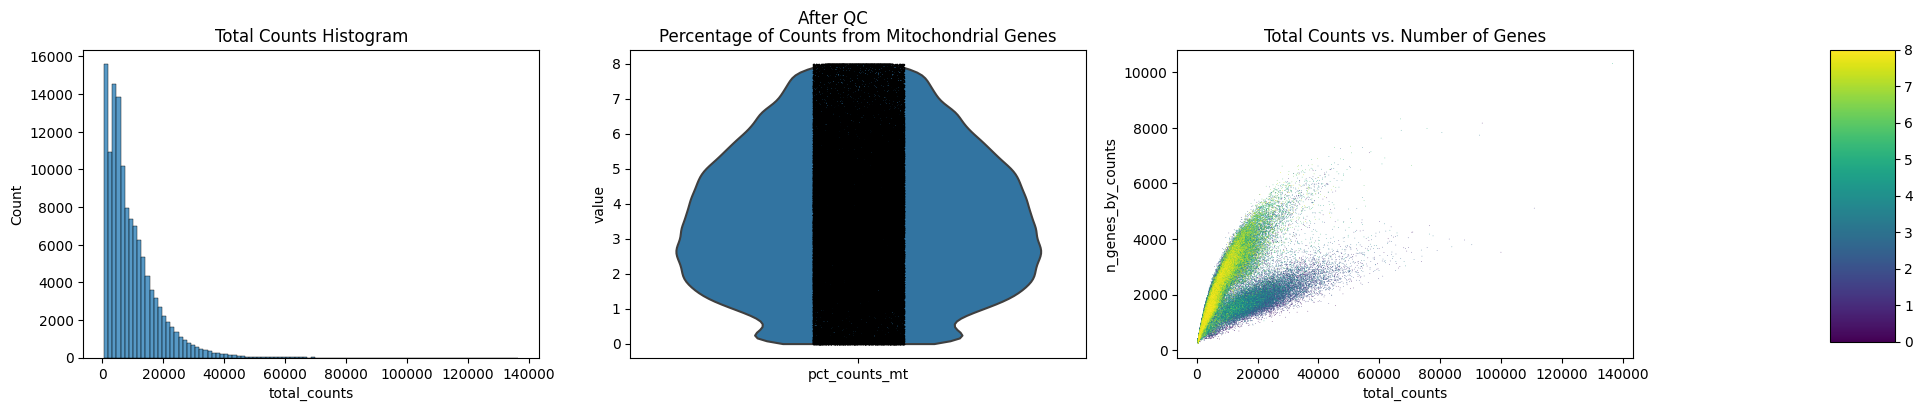

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
generate_qc_metrics(adata,axes)
fig.suptitle("Before QC")
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
generate_qc_metrics(combined,axes)
fig.suptitle("After QC")
plt.show()

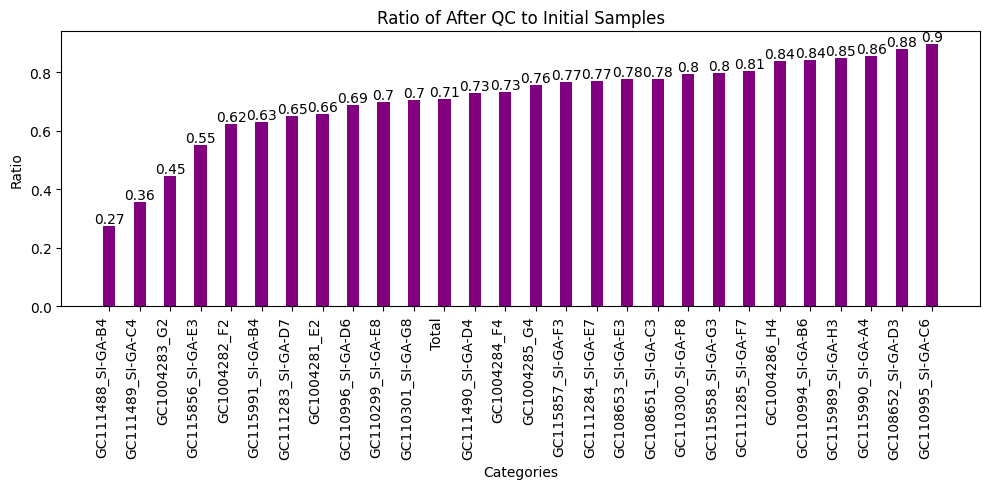

In [11]:
import matplotlib.pyplot as plt

# Calculate the ratio of After QC to Initial
ratios_dict = {key: value2 / value1 for key,(value1,value2) in qc_adatas_dict.items()}
ratios_dict = dict(sorted(ratios_dict.items(), key=lambda item: item[1]))
# Extract labels and values
labels = list(ratios_dict.keys())
ratios=ratios_dict.values()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.4  # Adjust the bar width as needed

# Plot the bar chart for ratios
bars = ax.bar(labels, ratios, bar_width, color='purple')

# Customize the plot
ax.set_title('Ratio of After QC to Initial Samples')
ax.set_xlabel('Categories')
ax.set_ylabel('Ratio')
ax.set_ylim(bottom=0)  # Ensure that the y-axis starts from 0

# Display the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=90, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


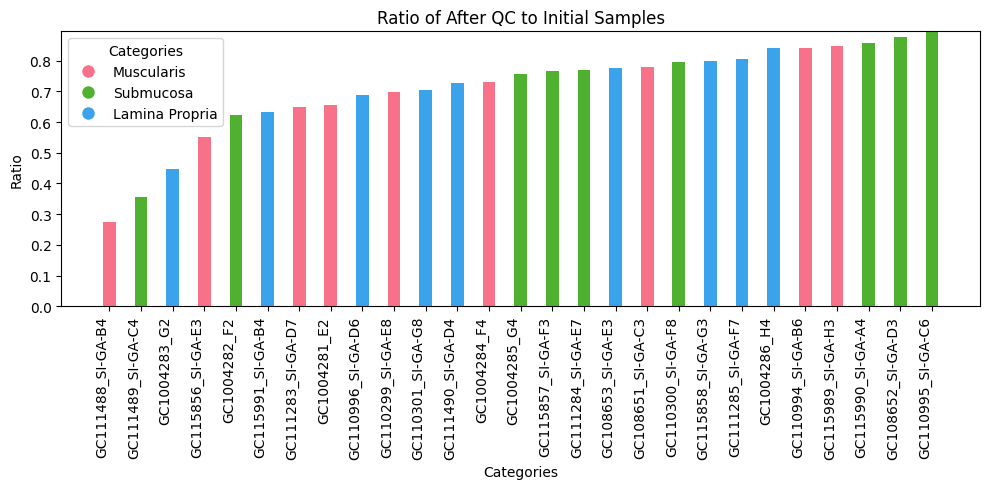

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ratio_barchart(qc_adatas_dict, merged, column='layer', title='Ratio of After QC to Initial Samples'):
    # Calculate ratios
    ratios_dict = {key: value2 / value1 for key, (value1, value2) in qc_adatas_dict.items() if key != "Total"}
    sorted_ratios = sorted(ratios_dict.items(), key=lambda item: item[1])

    # Extract labels and values
    labels, ratios = zip(*sorted_ratios)

    # Define a color mapping for categories using seaborn color palette
    code2column = merged.set_index("GC code")[column].to_dict()
    color_mapping = dict(zip(merged[column].unique(), sns.color_palette("husl", n_colors=len(merged[column].unique()))))

    # Plot the bar chart for ratios with different colors for each category
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(labels, ratios, width=0.4, color=[color_mapping[code2column[key]] for key in labels])

    # Customize the plot
    ax.set(title=title, xlabel='Categories', ylabel='Ratio', ylim=(0, max(ratios)))
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()

    # Create and display legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                       for label, color in color_mapping.items()]
    ax.legend(handles=legend_elements, title='Categories', loc='upper left')

    # Show the plot
    plt.show()


plot_ratio_barchart(qc_adatas_dict, merged, column='layer')

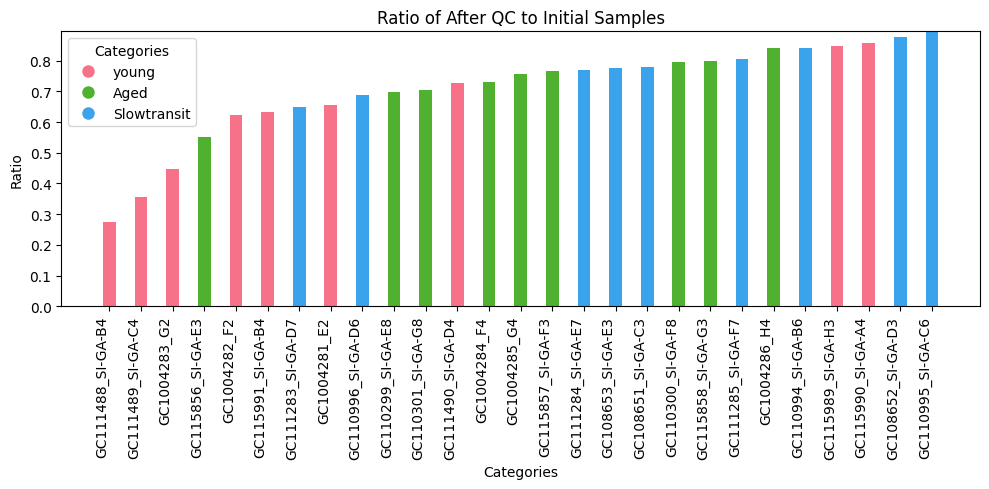

In [13]:
plot_ratio_barchart(qc_adatas_dict, merged, column='condition')

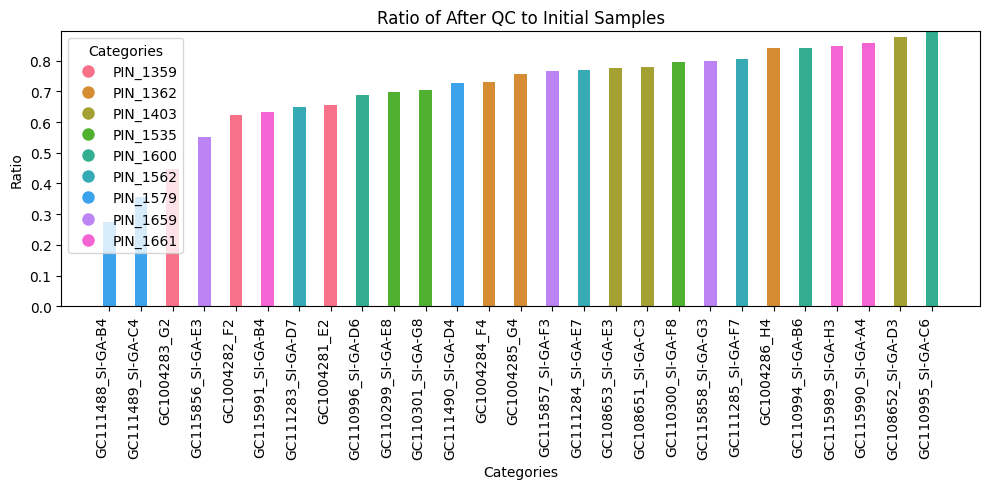

In [14]:
plot_ratio_barchart(qc_adatas_dict, merged, column='PIN')

In [15]:
merged["spot count after QC"]=merged["GC code"].apply(lambda x: qc_adatas_dict[x][1])
merged["ratio"]=merged["spot count after QC"]/merged["spot count"]
merged["removal perc"]=1 - merged["ratio"]
merged.sort_values(by="ratio", ascending=False)

GC code       PIN sample name           layer    condition  \
13  GC110995_SI-GA-C6  PIN_1600      1600_2       Submucosa  Slowtransit   
7   GC108652_SI-GA-D3  PIN_1403      1403_2       Submucosa  Slowtransit   
25  GC115990_SI-GA-A4  PIN_1661      1661_2       Submucosa        young   
24  GC115989_SI-GA-H3  PIN_1661      1661_1      Muscularis        young   
12  GC110994_SI-GA-B6  PIN_1600      1600_1      Muscularis  Slowtransit   
5        GC1004286_H4  PIN_1362      1362_3  Lamina Propria         Aged   
17  GC111285_SI-GA-F7  PIN_1562      1562_3  Lamina Propria  Slowtransit   
23  GC115858_SI-GA-G3  PIN_1659      1659_3  Lamina Propria         Aged   
10  GC110300_SI-GA-F8  PIN_1535      1535_2       Submucosa         Aged   
6   GC108651_SI-GA-C3  PIN_1403      1403_1      Muscularis  Slowtransit   
8   GC108653_SI-GA-E3  PIN_1403      1403_3  Lamina Propria  Slowtransit   
16  GC111284_SI-GA-E7  PIN_1562      1562_2       Submucosa  Slowtransit   
22  GC115857_SI-GA-F3  PIN_1659      1659_2       Submucosa         Aged   
4        GC1004285_G4  PIN_1362      1362_2       Submucosa         Aged   
3        GC1004284_F4  PIN_1362      1362_1      Muscularis         Aged   
20  GC111490_SI-GA-D4  PIN_1579      1579_3  Lamina Propria        young   
11  GC110301_SI-GA-G8  PIN_1535      1535_3  Lamina Propria         Aged   
9   GC110299_SI-GA-E8  PIN_1535      1535_1      Muscularis         Aged   
14  GC110996_SI-GA-D6  PIN_1600      1600_3  Lamina Propria  Slowtransit   
0        GC1004281_E2  PIN_1359      1359_1      Muscularis        young   
15  GC111283_SI-GA-D7  PIN_1562      1562_1      Muscularis  Slowtransit   
26  GC115991_SI-GA-B4  PIN_1661      1661_3  Lamina Propria        young   
1        GC1004282_F2  PIN_1359      1359_2       Submucosa        young   
21  GC115856_SI-GA-E3  PIN_1659      1659_1      Muscularis         Aged   
2        GC1004283_G2  PIN_1359      1359_3  Lamina Propria        young   
19  GC111489_SI-GA-C4  PIN_1579      1579_2       Submucosa        young   
18  GC111488_SI-GA-B4  PIN_1579      1579_1      Muscularis        young   

    spot count  spot count after QC     ratio  removal perc  
13        2610                 2338  0.895785      0.104215  
7         8045                 7070  0.878807      0.121193  
25       14859                12745  0.857729      0.142271  
24       10517                 8933  0.849387      0.150613  
12        8224                 6933  0.843020      0.156980  
5         6058                 5091  0.840376      0.159624  
17        3729                 3003  0.805310      0.194690  
23        5715                 4568  0.799300      0.200700  
10        6848                 5445  0.795123      0.204877  
6         3337                 2597  0.778244      0.221756  
8         6035                 4690  0.777133      0.222867  
16        6394                 4930  0.771035      0.228965  
22        3755                 2877  0.766178      0.233822  
4         6894                 5227  0.758196      0.241804  
3         6808                 4980  0.731492      0.268508  
20        7635                 5564  0.728749      0.271251  
11        8547                 6021  0.704458      0.295542  
9         5771                 4036  0.699359      0.300641  
14        2114                 1454  0.687796      0.312204  
0         6531                 4290  0.656867      0.343133  
15        3829                 2486  0.649256      0.350744  
26        9488                 5990  0.631324      0.368676  
1         5395                 3356  0.622057      0.377943  
21        8333                 4595  0.551422      0.448578  
2         7525                 3359  0.446379      0.553621  
19        6023                 2147  0.356467      0.643533  
18        7589                 2080  0.274081      0.725919

### Doublets Detection

In [16]:
%matplotlib inline
import scrublet as scr
import matplotlib.pyplot as plt

def detect_doublets(adata):
    # Create Scrublet object
    scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.06)
    
    # Perform doublet detection
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                              min_cells=3, 
                                                              min_gene_variability_pctl=85, 
                                                              n_prin_comps=30)
    scrub.plot_histogram()
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
    scrub.plot_embedding('UMAP', order_points=True)

    # Add predicted_doublets and doublet_scores to observation annotations
    adata.obs['predicted_doublets'] = predicted_doublets
    adata.obs['doublet_scores'] = doublet_scores

    # Show the plots
    plt.show()


Sample: GC1004281_E2
Tissue: Muscularis
Preprocessing...


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 3.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.0%
Elapsed time: 4.9 seconds


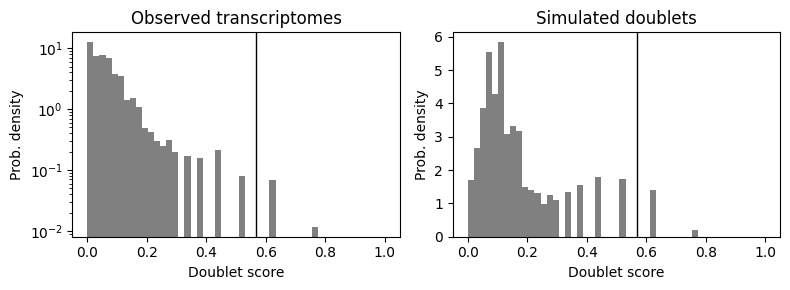

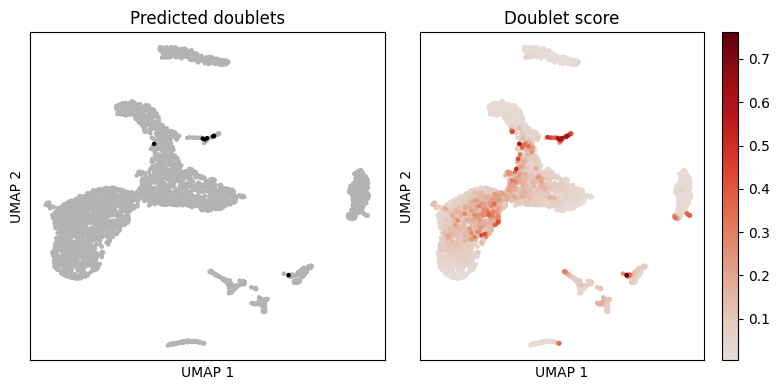

Sample: GC1004282_F2
Tissue: Submucosa
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 4.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.8%
Elapsed time: 3.0 seconds


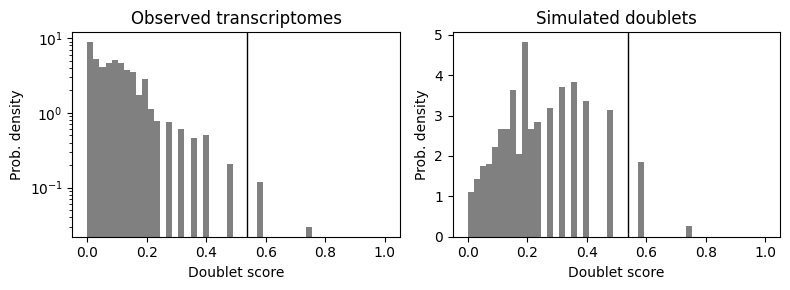

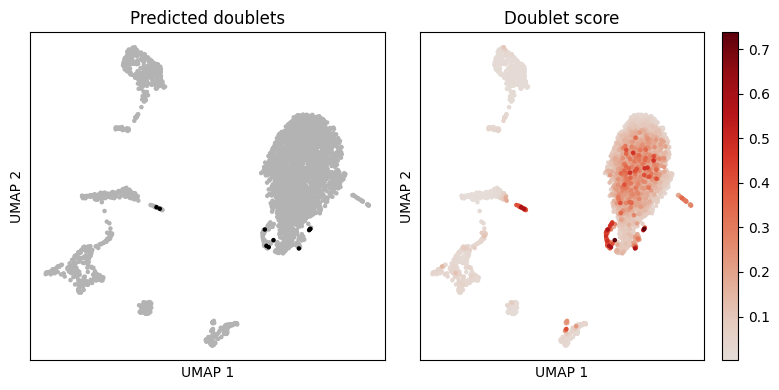

Sample: GC1004283_G2
Tissue: Lamina Propria
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 12.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 2.4%
Elapsed time: 2.6 seconds


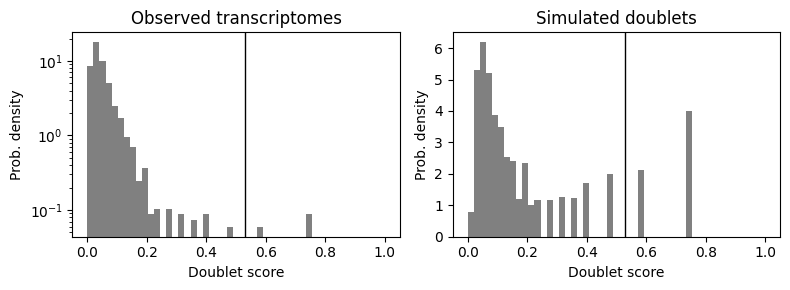

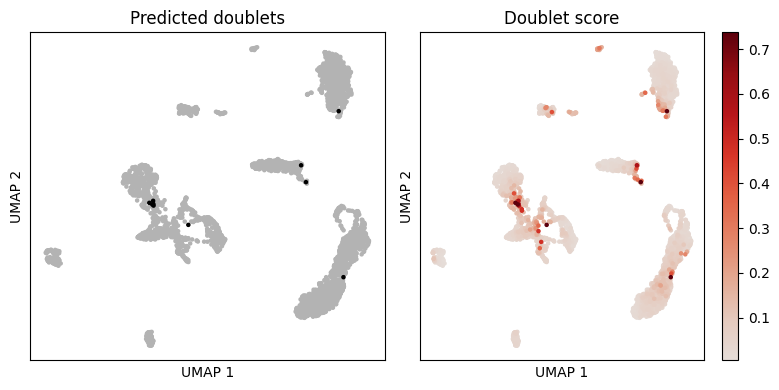

Sample: GC1004284_F4
Tissue: Muscularis
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 1.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 13.4%
Elapsed time: 5.0 seconds


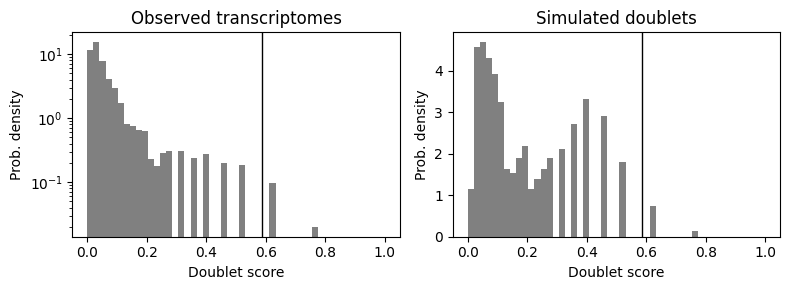

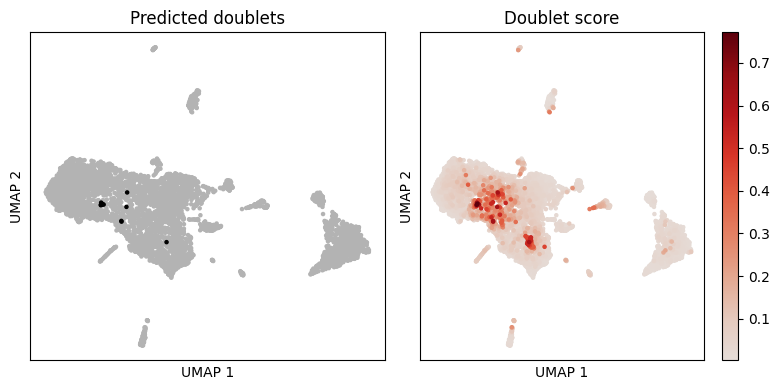

Sample: GC1004285_G4
Tissue: Submucosa
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.5%
Elapsed time: 4.3 seconds


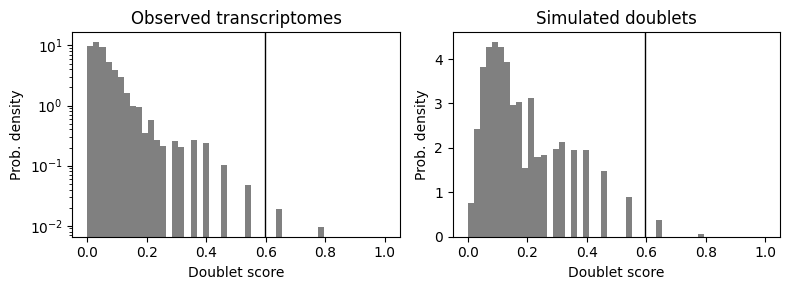

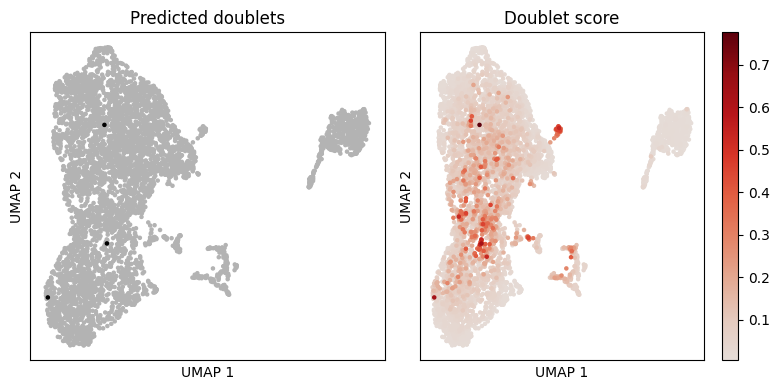

Sample: GC1004286_H4
Tissue: Lamina Propria
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 34.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.5%
Elapsed time: 5.5 seconds


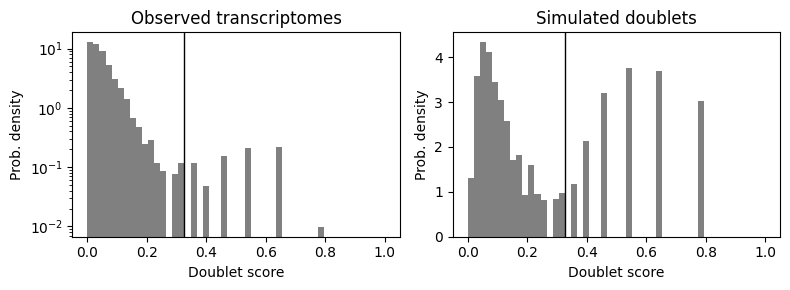

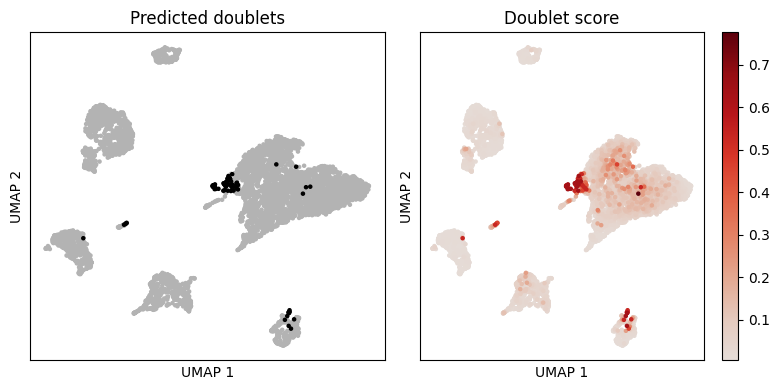

Sample: GC108651_SI-GA-C3
Tissue: Muscularis
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 23.3%
Elapsed time: 1.7 seconds


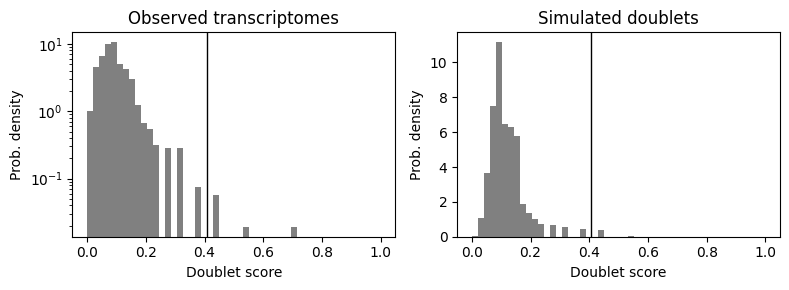

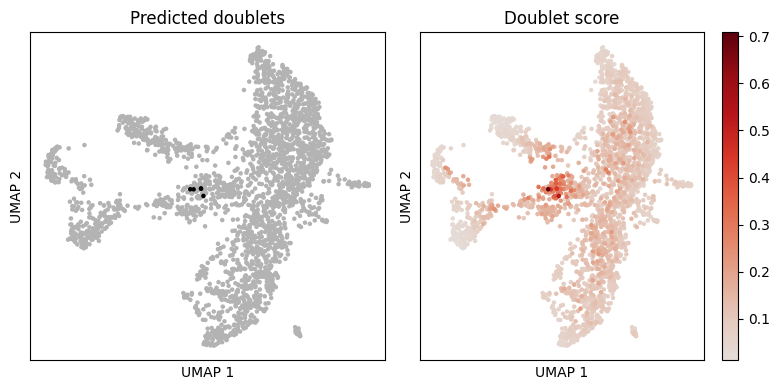

Sample: GC108652_SI-GA-D3
Tissue: Submucosa
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 32.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.9%
Elapsed time: 6.1 seconds


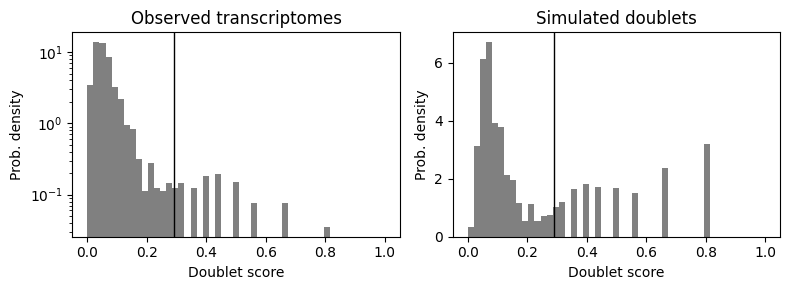

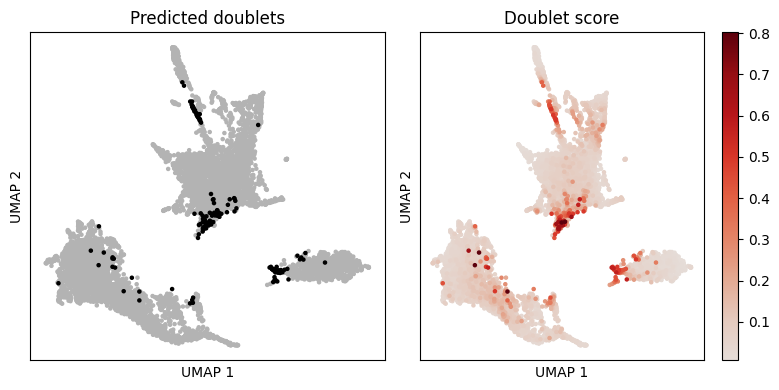

Sample: GC108653_SI-GA-E3
Tissue: Lamina Propria
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 9.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.7%
Elapsed time: 4.0 seconds


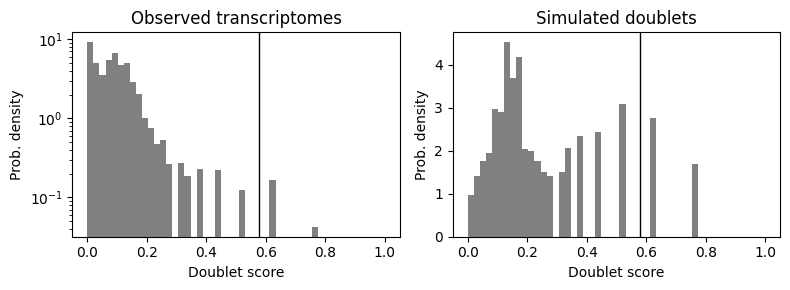

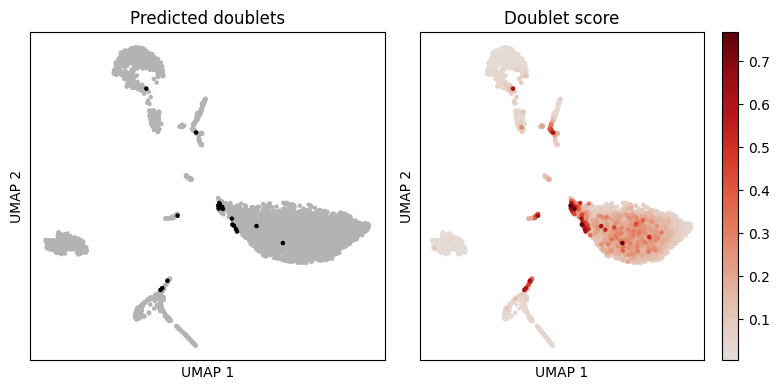

Sample: GC110299_SI-GA-E8
Tissue: Muscularis
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 10.8%
Elapsed time: 4.4 seconds


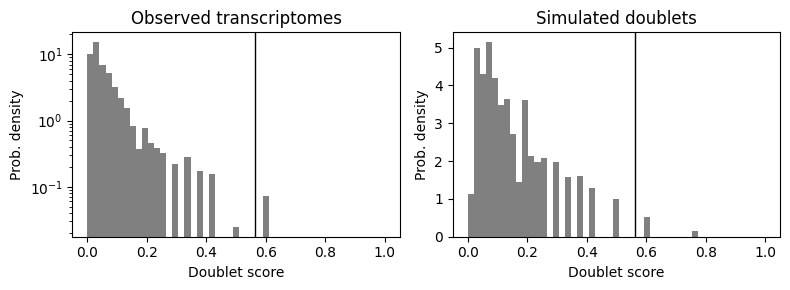

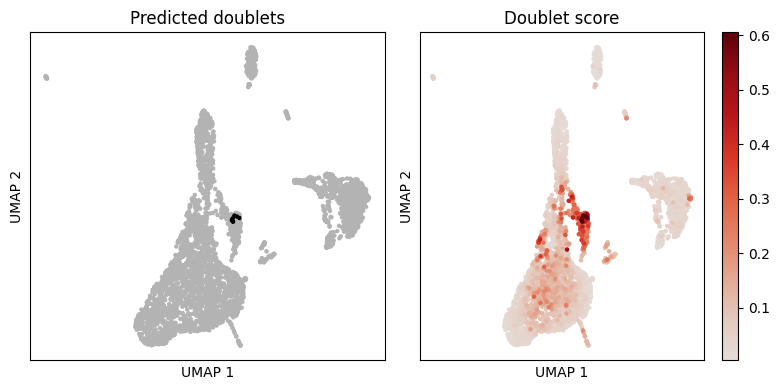

Sample: GC110300_SI-GA-F8
Tissue: Submucosa
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 38.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 10.4%
Elapsed time: 4.8 seconds


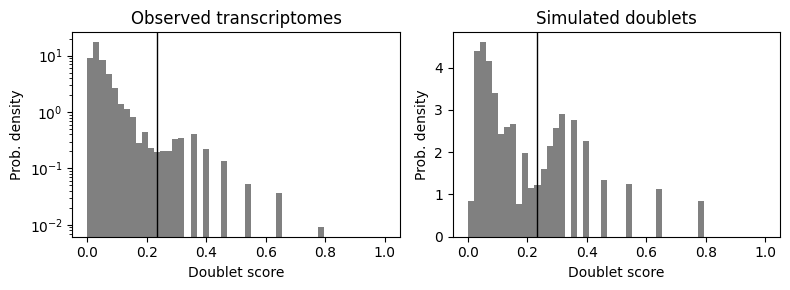

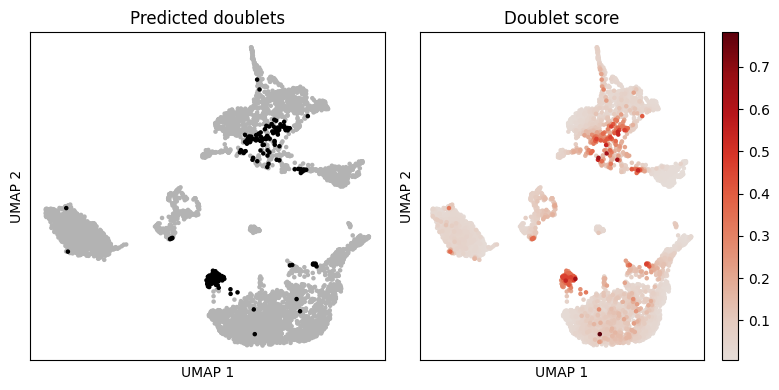

Sample: GC110301_SI-GA-G8
Tissue: Lamina Propria
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.0%
Elapsed time: 4.5 seconds


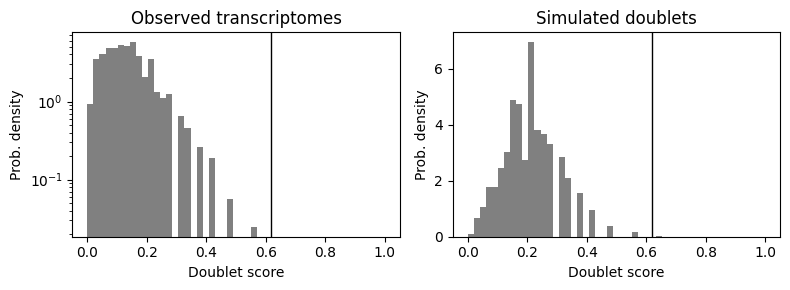

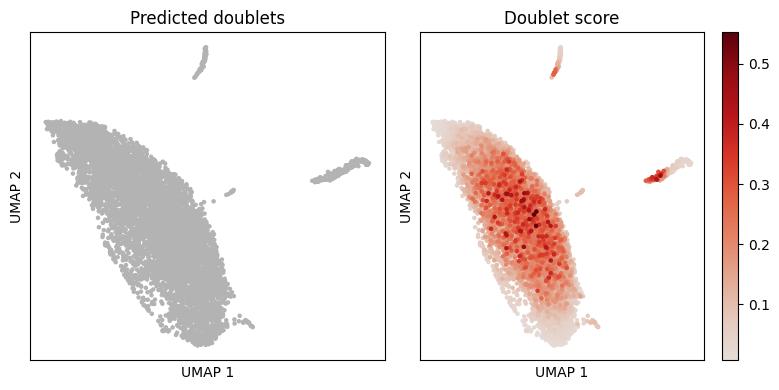

Sample: GC110994_SI-GA-B6
Tissue: Muscularis
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 27.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.0%
Elapsed time: 6.8 seconds


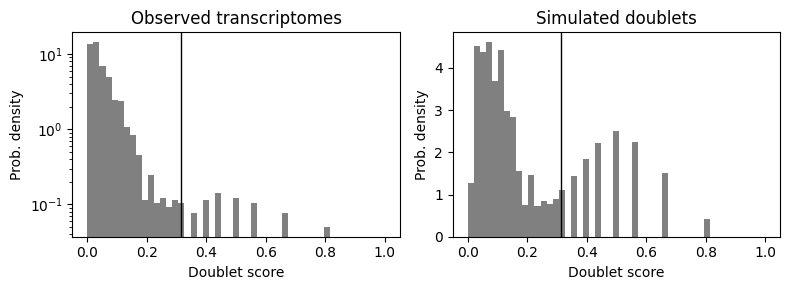

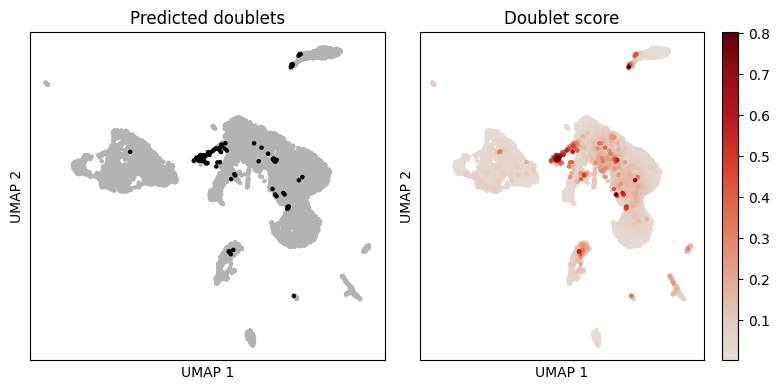

Sample: GC110995_SI-GA-C6
Tissue: Submucosa
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 29.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.4%
Elapsed time: 2.0 seconds


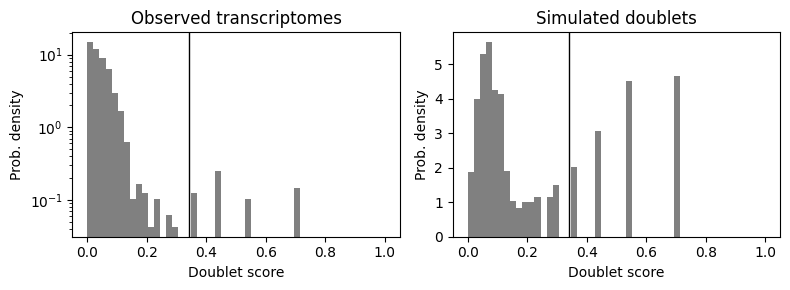

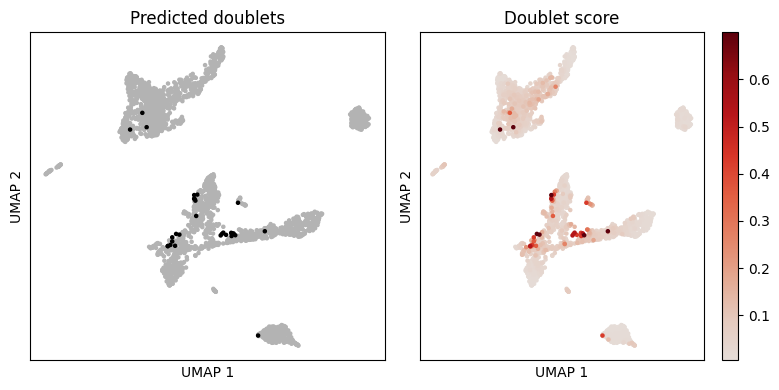

Sample: GC110996_SI-GA-D6
Tissue: Lamina Propria
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 32.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.9%
Elapsed time: 1.0 seconds


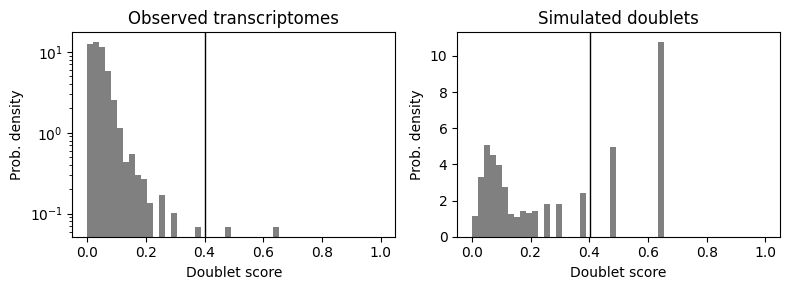

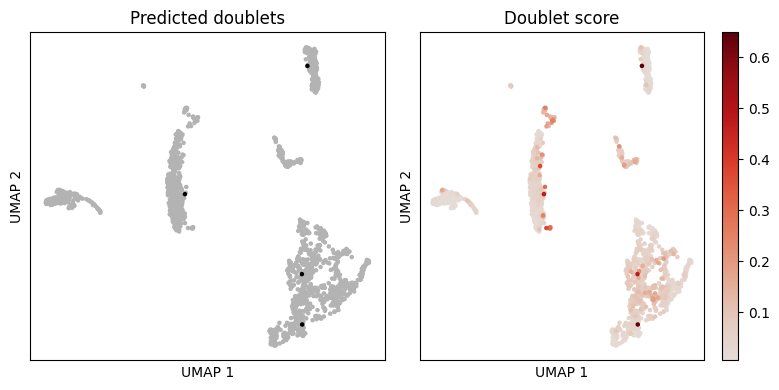

Sample: GC111283_SI-GA-D7
Tissue: Muscularis
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 8.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 8.7%
Elapsed time: 2.3 seconds


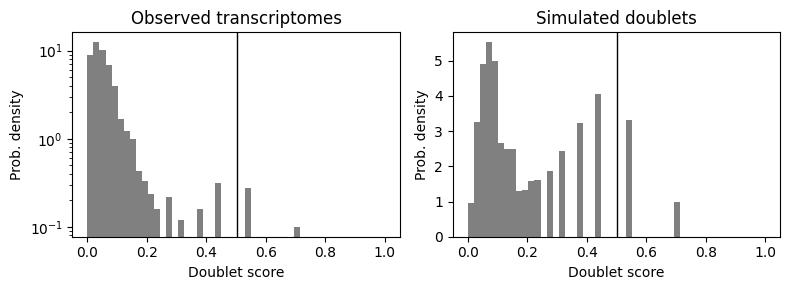

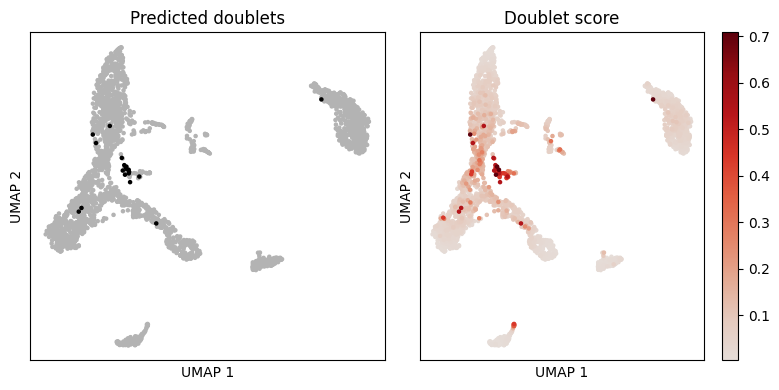

Sample: GC111284_SI-GA-E7
Tissue: Submucosa
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.22
Detected doublet rate = 4.3%
Estimated detectable doublet fraction = 49.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 8.6%
Elapsed time: 4.7 seconds


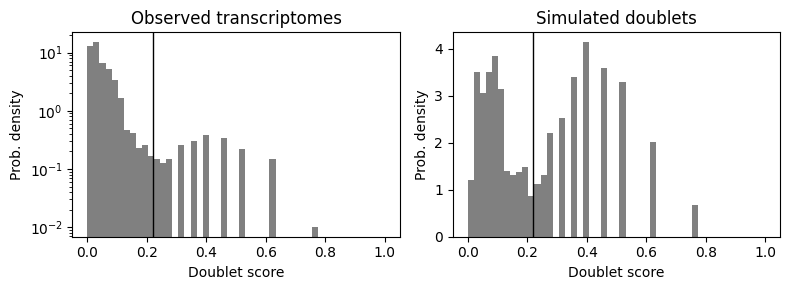

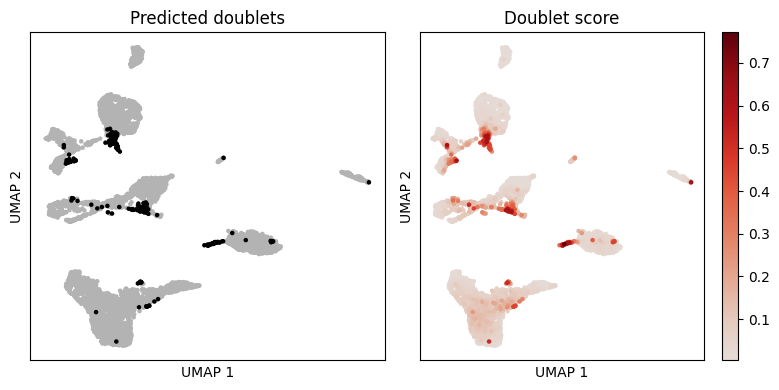

Sample: GC111285_SI-GA-F7
Tissue: Lamina Propria
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 13.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.5%
Elapsed time: 2.9 seconds


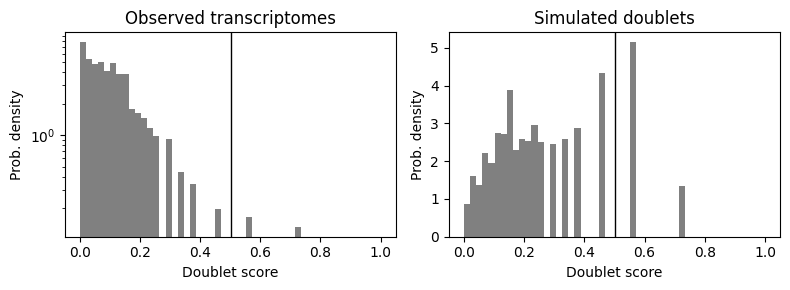

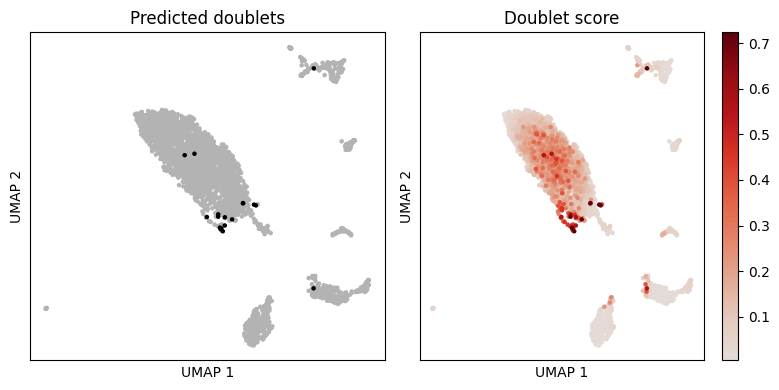

Sample: GC111488_SI-GA-B4
Tissue: Muscularis
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.26
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 29.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 7.3%
Elapsed time: 1.9 seconds


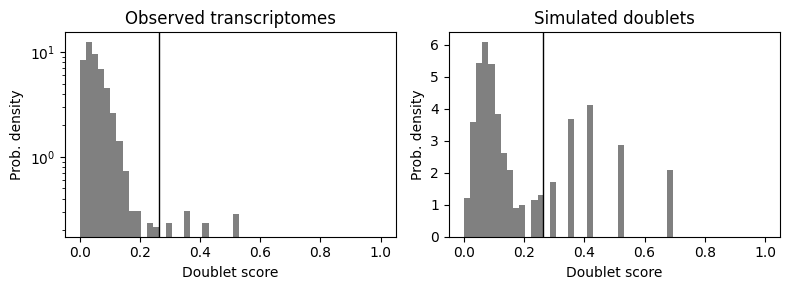

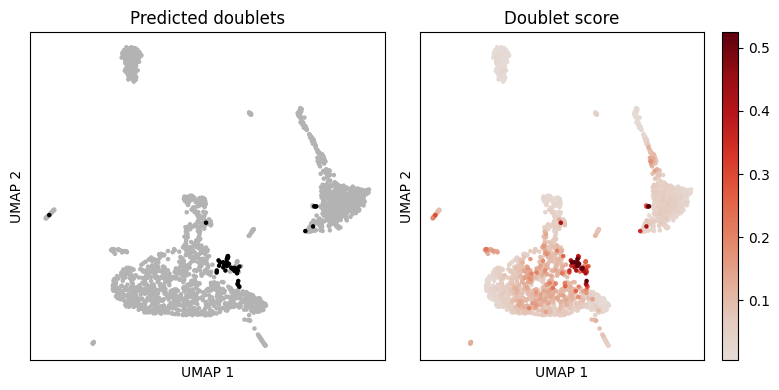

Sample: GC111489_SI-GA-C4
Tissue: Submucosa
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 7.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.5%
Elapsed time: 2.1 seconds


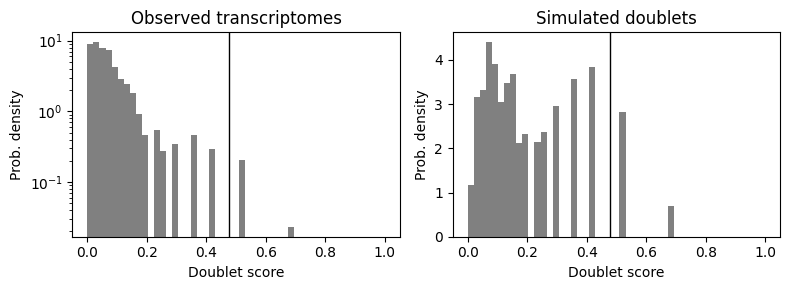

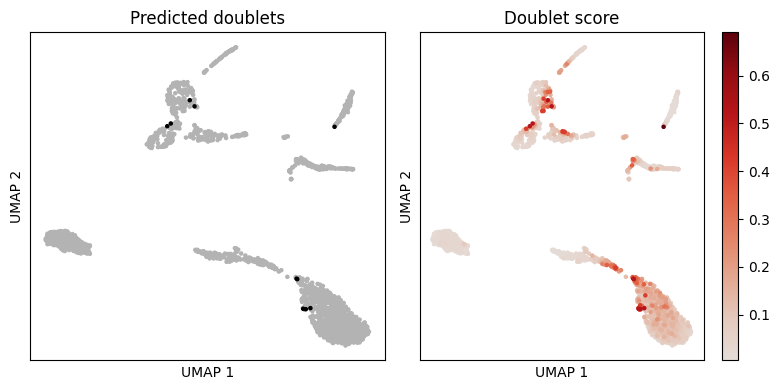

Sample: GC111490_SI-GA-D4
Tissue: Lamina Propria
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 16.7%
Elapsed time: 5.0 seconds


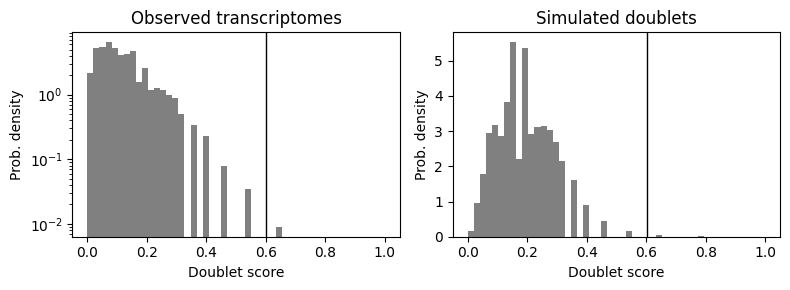

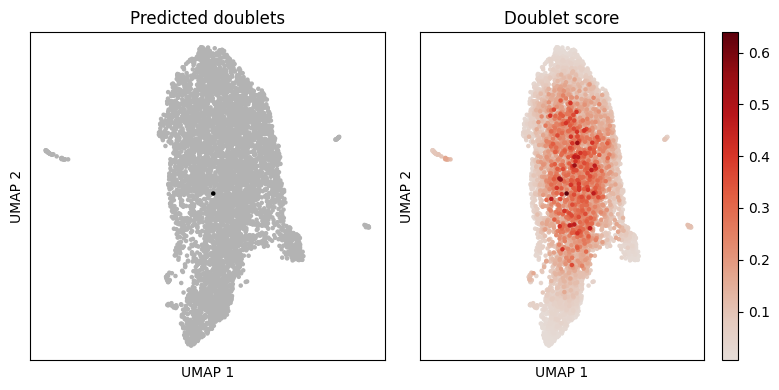

Sample: GC115856_SI-GA-E3
Tissue: Muscularis
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 10.8%
Elapsed time: 5.1 seconds


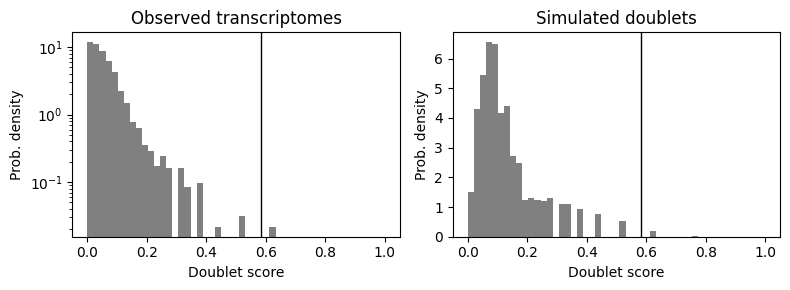

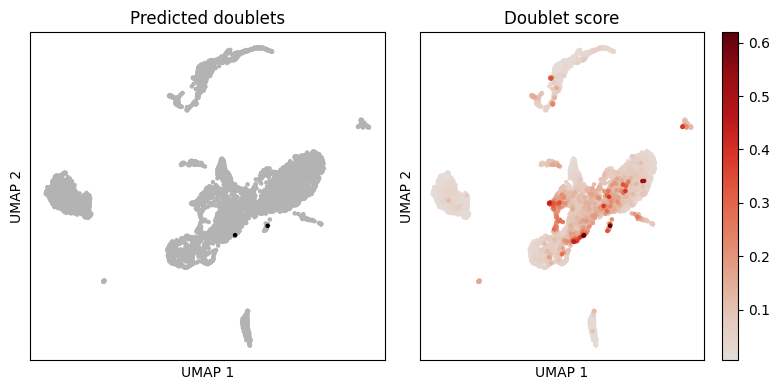

Sample: GC115857_SI-GA-F3
Tissue: Submucosa
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 12.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.9%
Elapsed time: 3.6 seconds


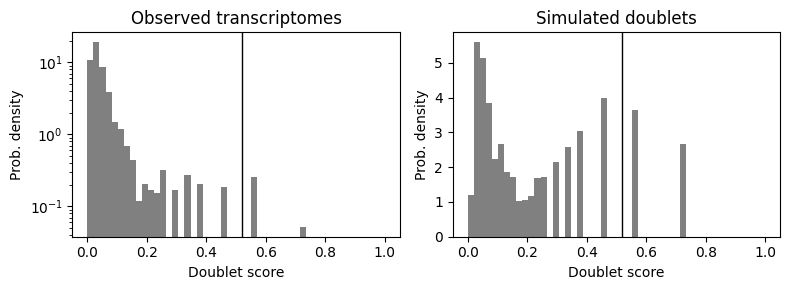

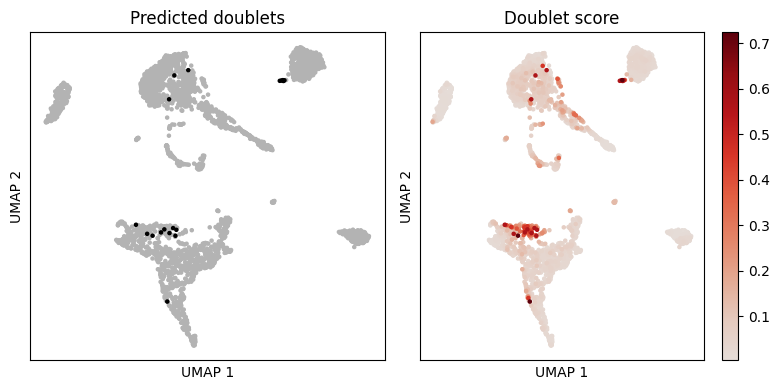

Sample: GC115858_SI-GA-G3
Tissue: Lamina Propria
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.26
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 47.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.9%
Elapsed time: 4.6 seconds


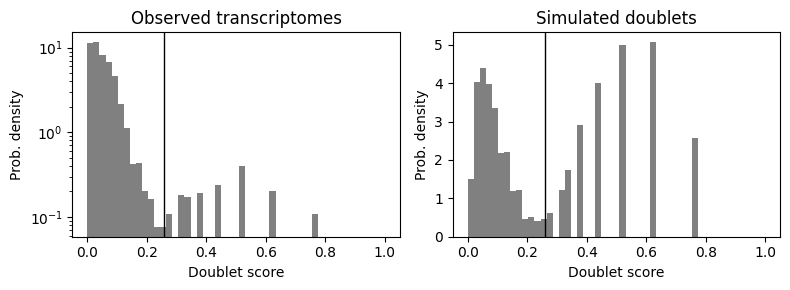

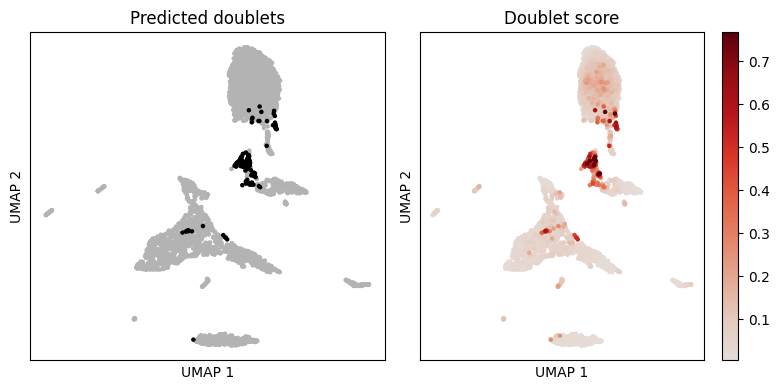

Sample: GC115989_SI-GA-H3
Tissue: Muscularis
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 2.4%
Elapsed time: 9.7 seconds


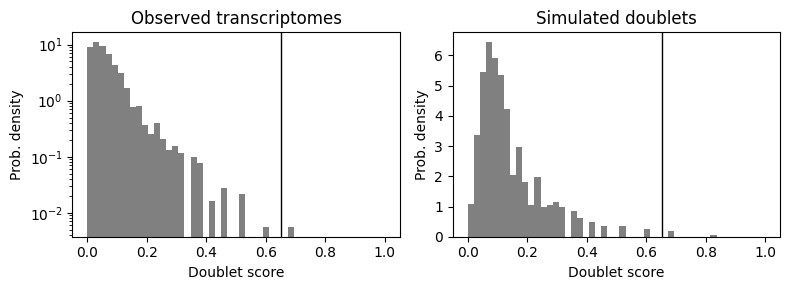

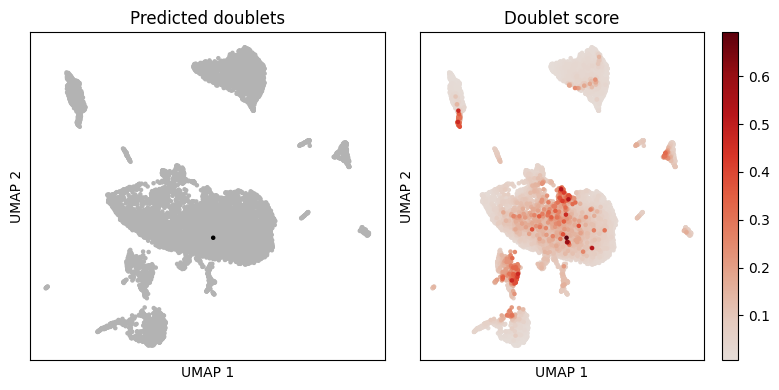

Sample: GC115990_SI-GA-A4
Tissue: Submucosa
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.69
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 2.4%
Elapsed time: 13.0 seconds


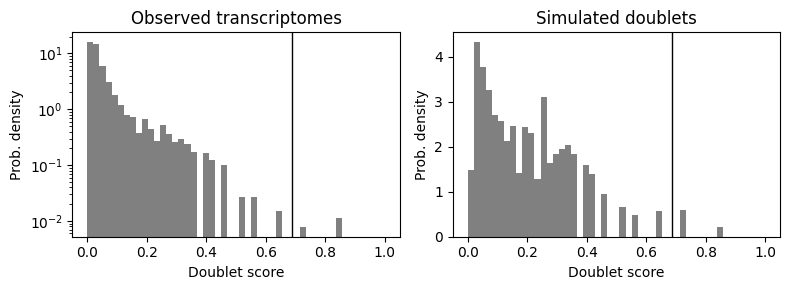

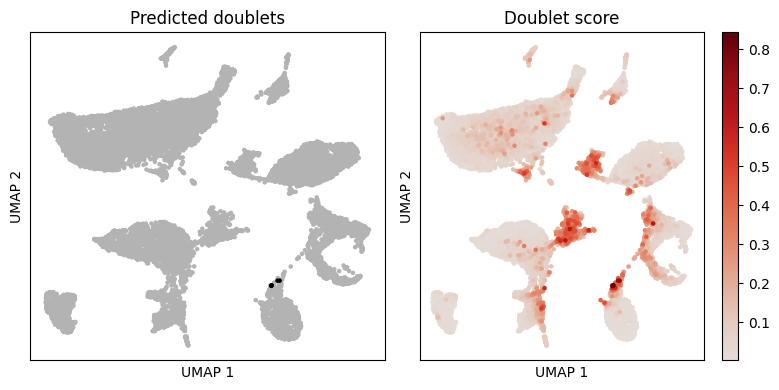

Sample: GC115991_SI-GA-B4
Tissue: Lamina Propria
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 16.7%
Elapsed time: 6.5 seconds


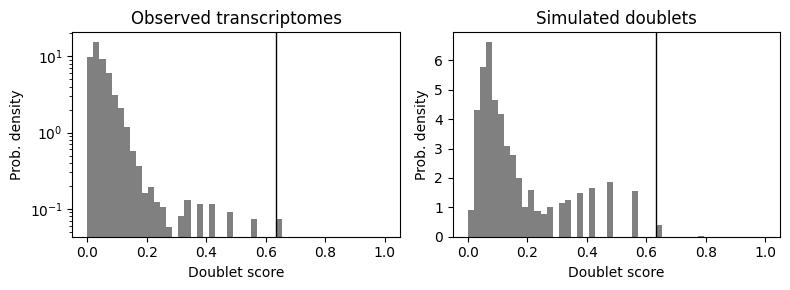

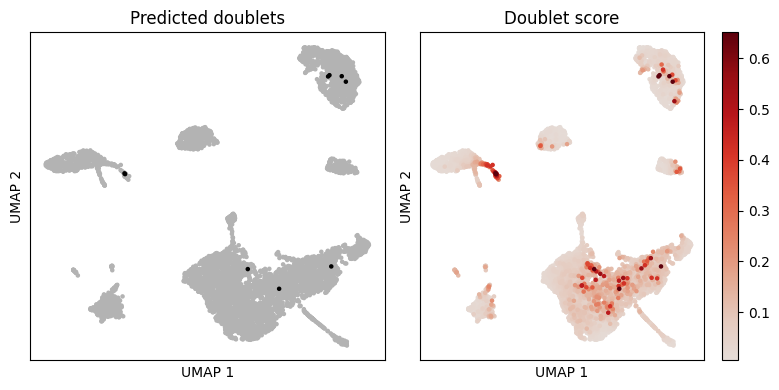

In [17]:
samples=adata.obs["batch"].unique()
for i,sample in enumerate(samples):
    print(f"Sample: {sample}")
    print(f"Tissue: {merged.loc[merged['GC code']==sample,'layer'].values[0]}")
    detect_doublets(qc_adatas[i])

In [98]:
import anndata as ann
import os
combined = ann.concat(qc_adatas, merge="same")
print(combined.obs["predicted_doublets"].value_counts())
combined.write(os.path.join("/media/gambino/students_workdir/ibp","combined_qced_filtered_counts_13_11.h5"))

predicted_doublets
False    125642
True       1163
Name: count, dtype: int64


## Normalization

In [3]:
import os
combined = anndata.read(os.path.join("/media/gambino/students_workdir/ibp","combined_qced_filtered_counts_13_11.h5"))

Normalize accross a dataset or per cell, and is it per sample, also why number of spots so different, different layers-different gene counts,

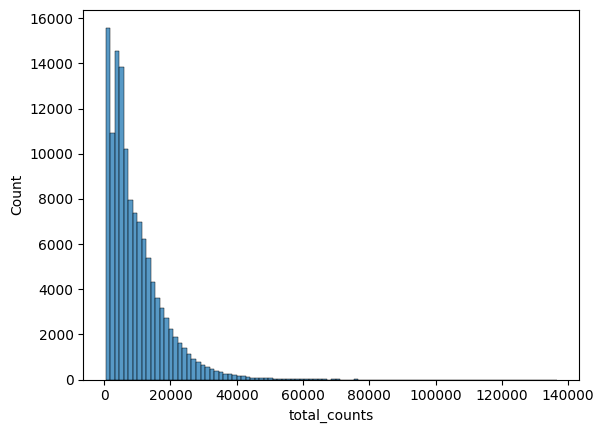

In [3]:
p1 = sns.histplot(combined.obs["total_counts"], bins=100, kde=False)

### Shifted logarithm Normalization

In [5]:
scales_counts = sc.pp.normalize_total(combined, target_sum=None, inplace=False)
combined.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:00)


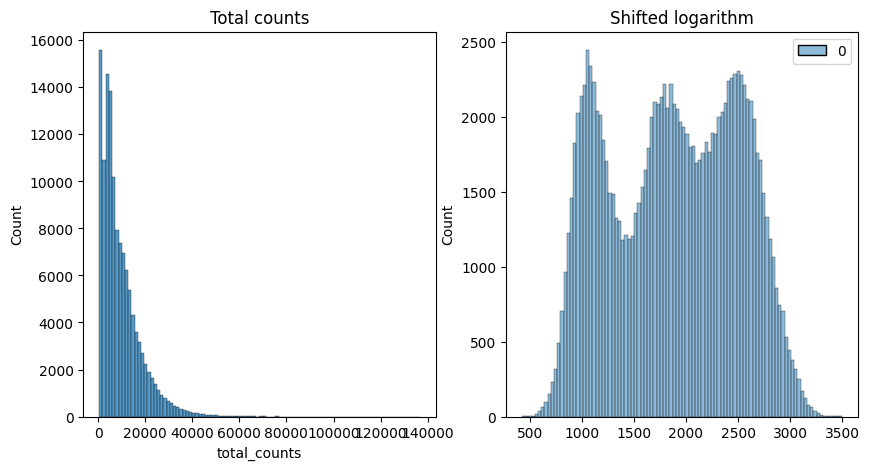

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(combined.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(combined.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

### Analytic Pearson residuals

In [7]:
from scipy.sparse import csr_matrix
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(combined, inplace=False)
combined.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

computing analytic Pearson residuals on adata.X
    finished (0:00:41)


: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(combined.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    combined.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

In [ ]:
combined.write(os.path.join("/media/gambino/students_workdir/ibp","combined_normalizedglobal_qced_filtered_counts_13_11.h5"))

### Normalize Every Sample First then Normalize Whole

In [20]:
import matplotlib.pyplot as plt

def normalize_subset(adata,axes):
    scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
    adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)   
    p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
    axes[0].set_title("Total counts")
    p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
    axes[1].set_title("Shifted logarithm")
    plt.show()
    return adata
    

Sample: GC1004281_E2
Tissue: Muscularis
normalizing counts per cell
    finished (0:00:00)


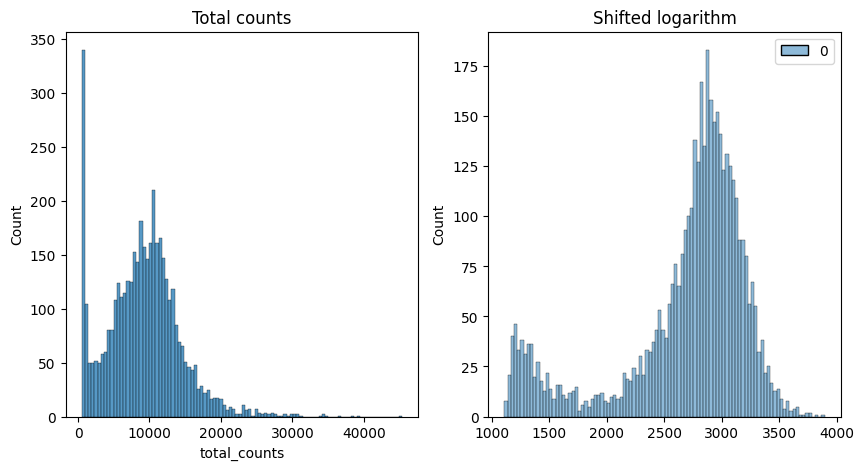

Sample: GC1004282_F2
Tissue: Submucosa
normalizing counts per cell
    finished (0:00:00)


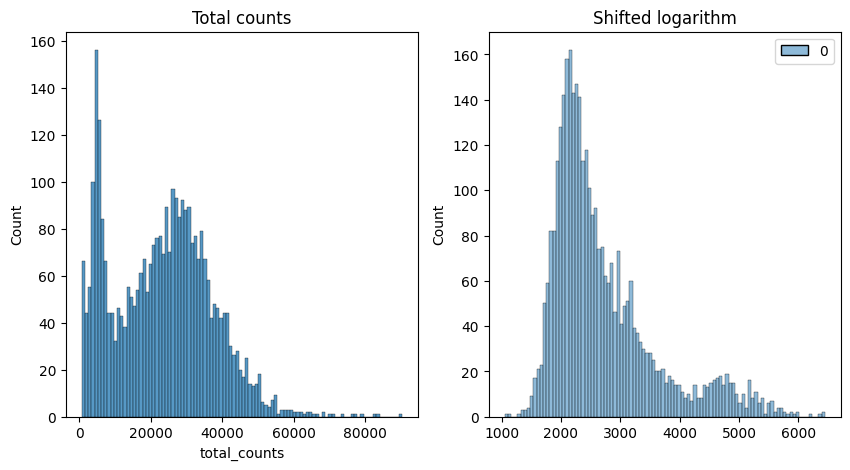

Sample: GC1004283_G2
Tissue: Lamina Propria
normalizing counts per cell
    finished (0:00:00)


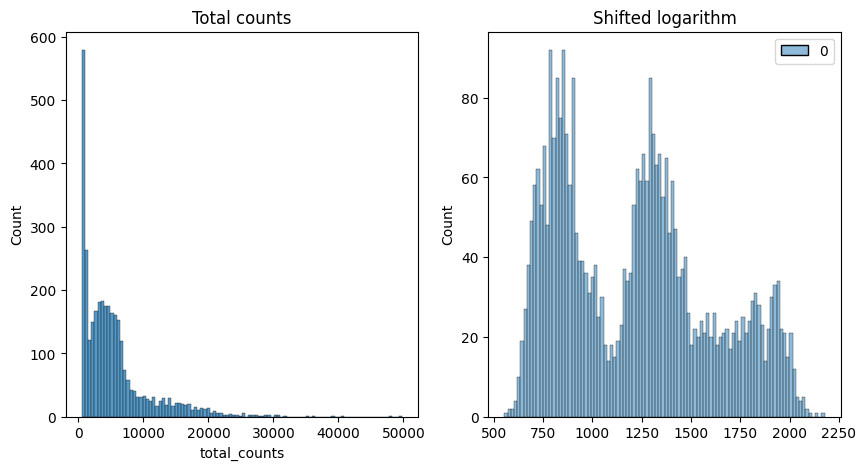

Sample: GC1004284_F4
Tissue: Muscularis
normalizing counts per cell
    finished (0:00:00)


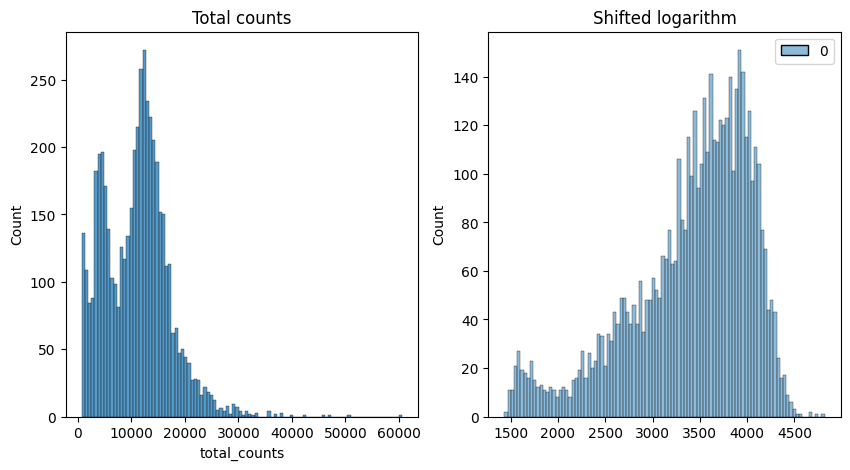

Sample: GC1004285_G4
Tissue: Submucosa
normalizing counts per cell
    finished (0:00:00)


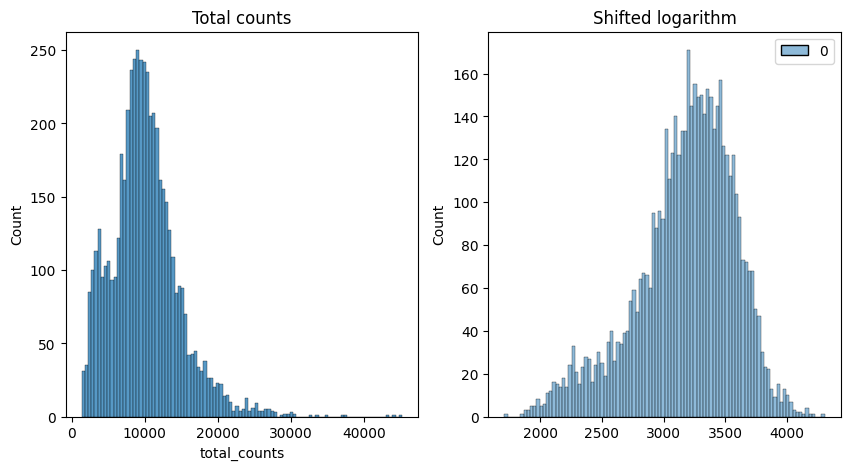

Sample: GC1004286_H4
Tissue: Lamina Propria
normalizing counts per cell
    finished (0:00:00)


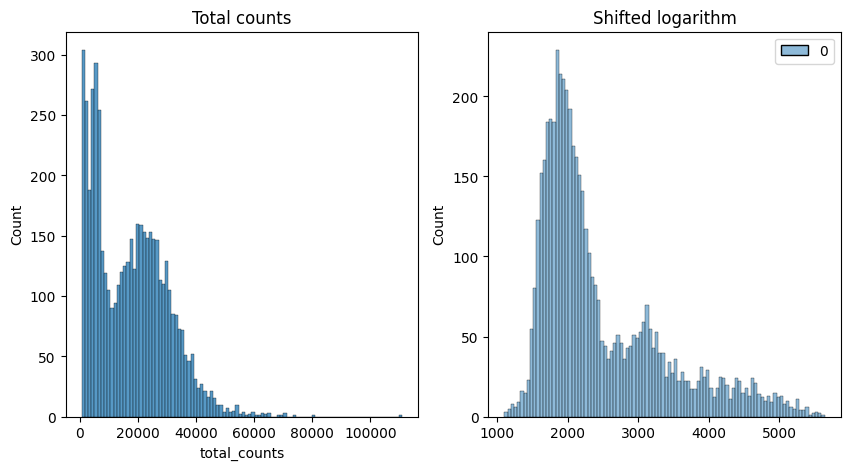

Sample: GC108651_SI-GA-C3
Tissue: Muscularis
normalizing counts per cell
    finished (0:00:00)


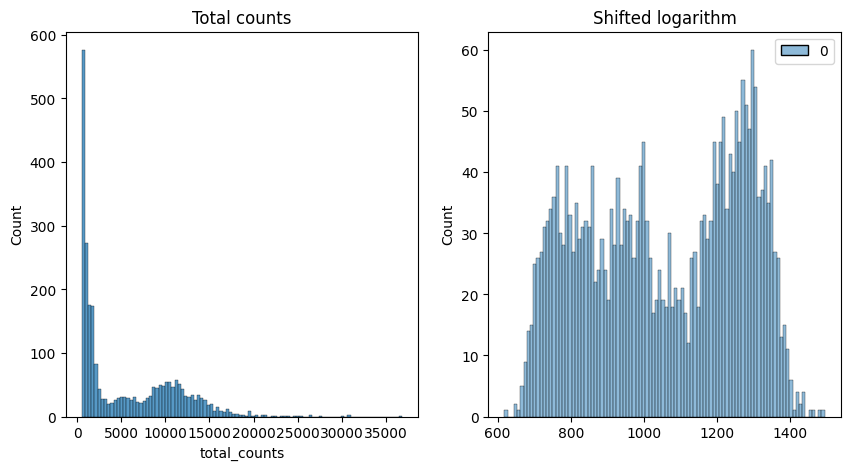

Sample: GC108652_SI-GA-D3
Tissue: Submucosa
normalizing counts per cell
    finished (0:00:00)


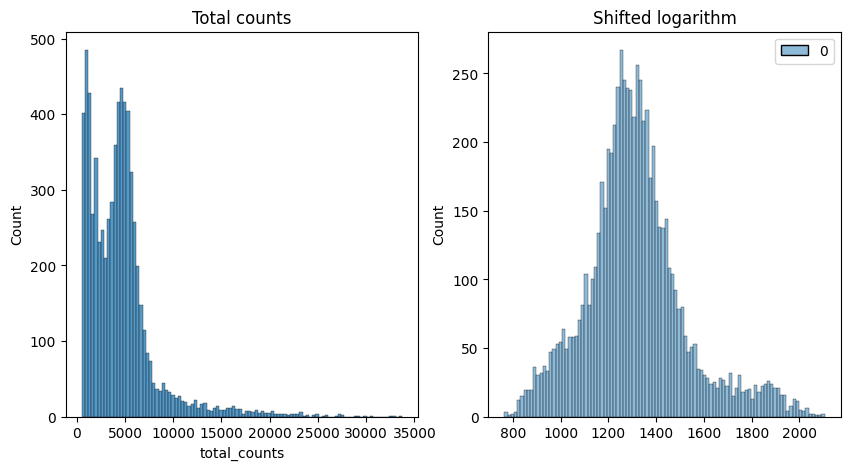

Sample: GC108653_SI-GA-E3
Tissue: Lamina Propria
normalizing counts per cell
    finished (0:00:00)


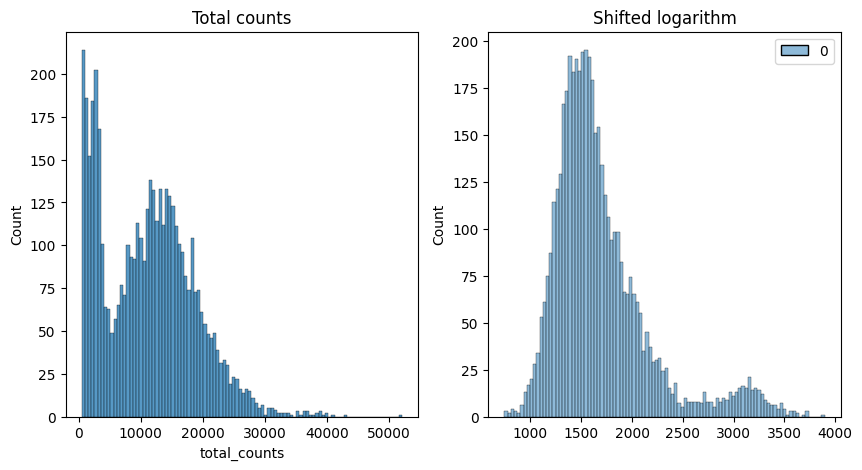

Sample: GC110299_SI-GA-E8
Tissue: Muscularis
normalizing counts per cell
    finished (0:00:00)


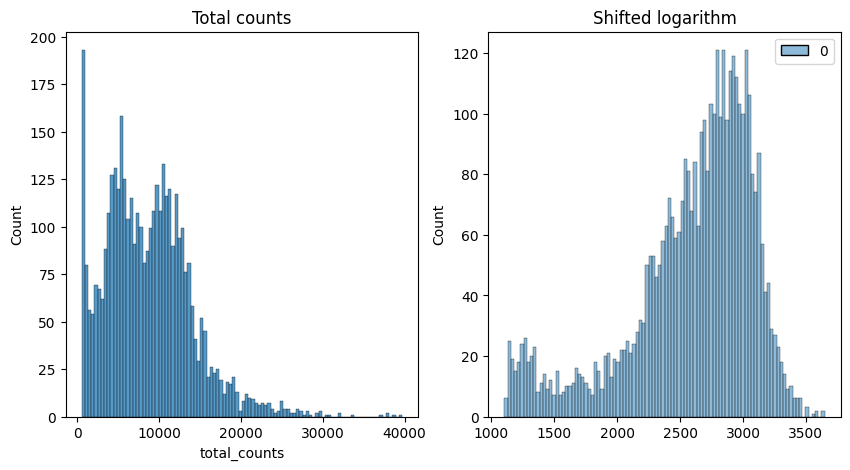

Sample: GC110300_SI-GA-F8
Tissue: Submucosa
normalizing counts per cell
    finished (0:00:00)


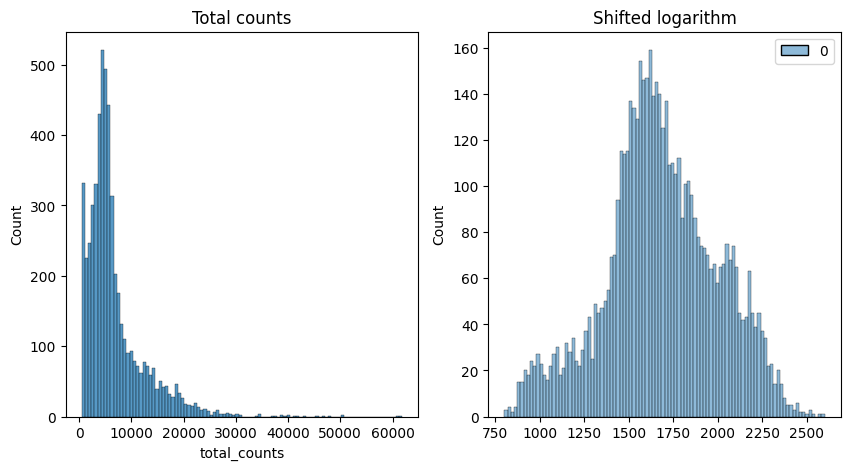

Sample: GC110301_SI-GA-G8
Tissue: Lamina Propria
normalizing counts per cell
    finished (0:00:00)


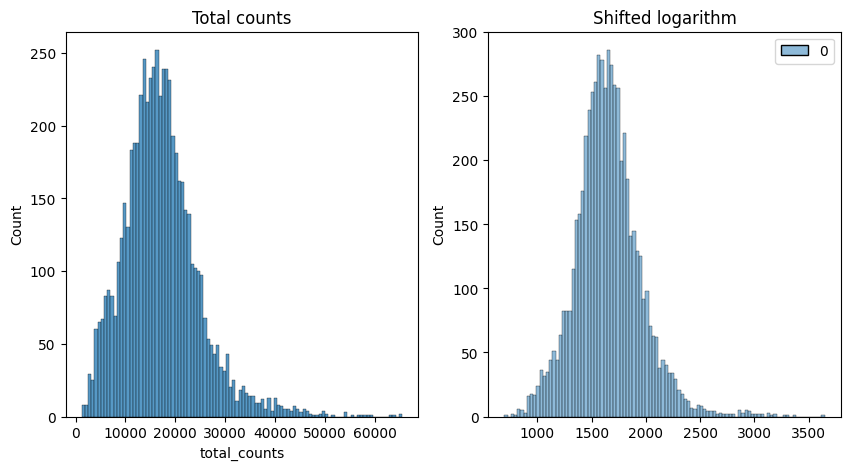

Sample: GC110994_SI-GA-B6
Tissue: Muscularis
normalizing counts per cell
    finished (0:00:00)


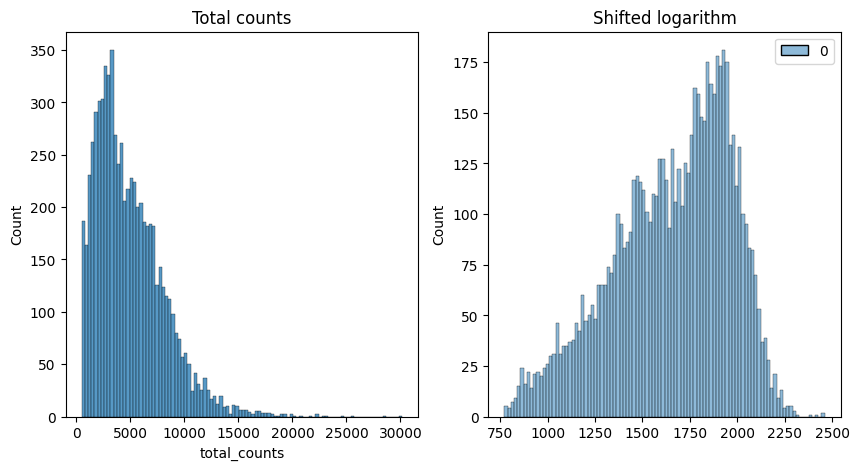

Sample: GC110995_SI-GA-C6
Tissue: Submucosa
normalizing counts per cell
    finished (0:00:00)


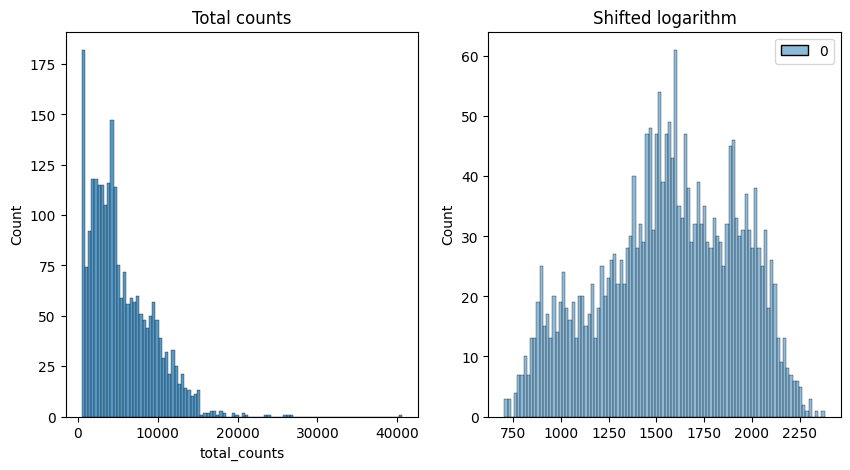

Sample: GC110996_SI-GA-D6
Tissue: Lamina Propria
normalizing counts per cell
    finished (0:00:00)


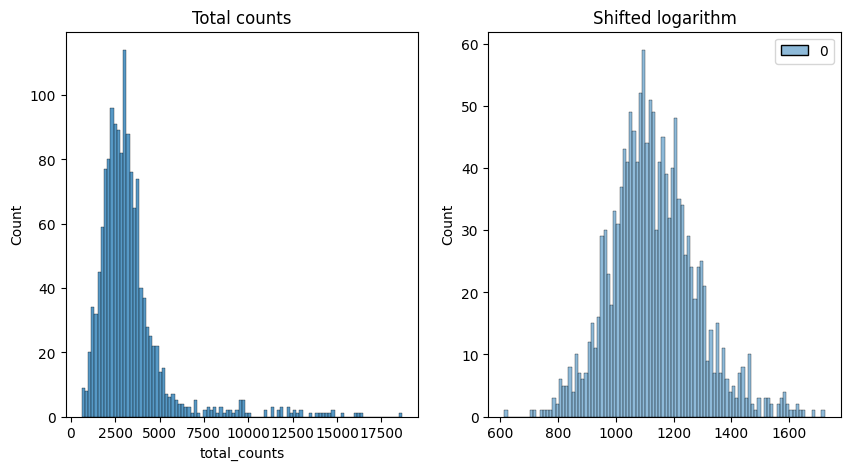

Sample: GC111283_SI-GA-D7
Tissue: Muscularis
normalizing counts per cell
    finished (0:00:00)


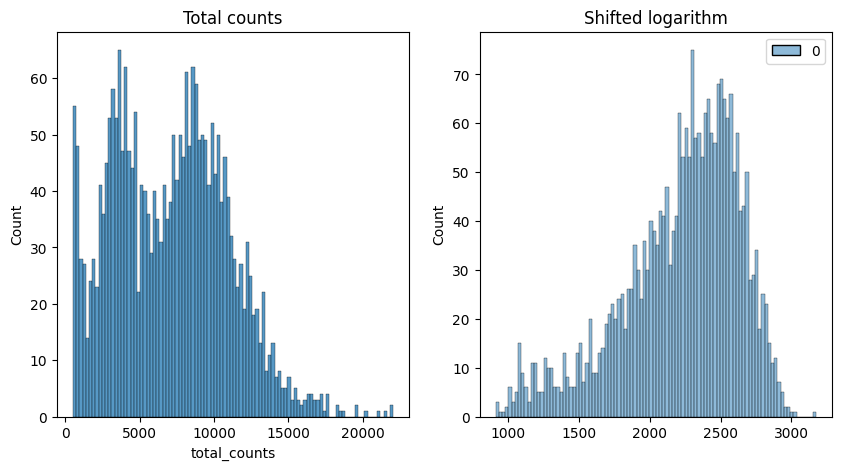

Sample: GC111284_SI-GA-E7
Tissue: Submucosa
normalizing counts per cell
    finished (0:00:00)


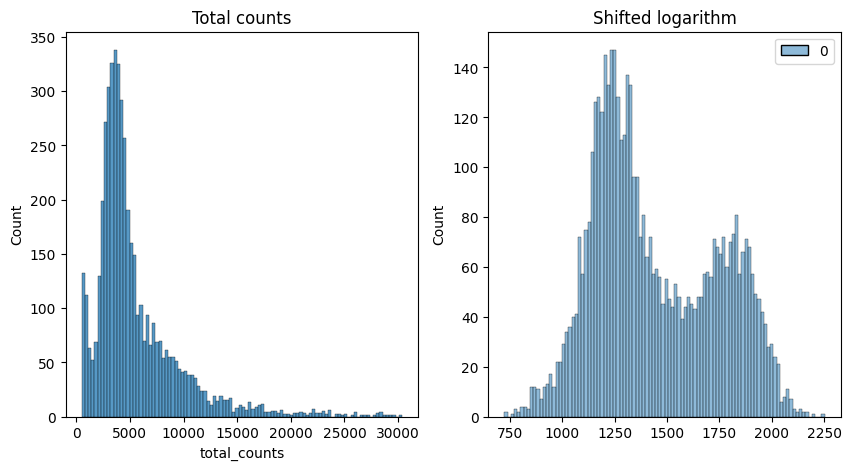

Sample: GC111285_SI-GA-F7
Tissue: Lamina Propria
normalizing counts per cell
    finished (0:00:00)


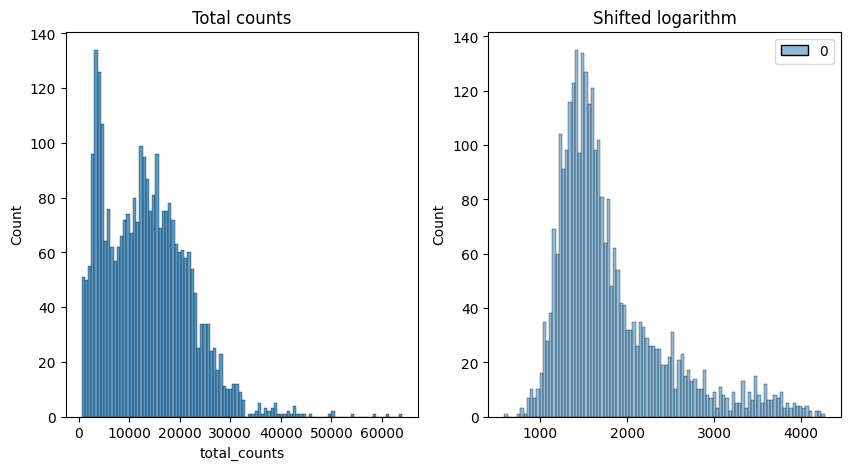

Sample: GC111488_SI-GA-B4
Tissue: Muscularis
normalizing counts per cell
    finished (0:00:00)


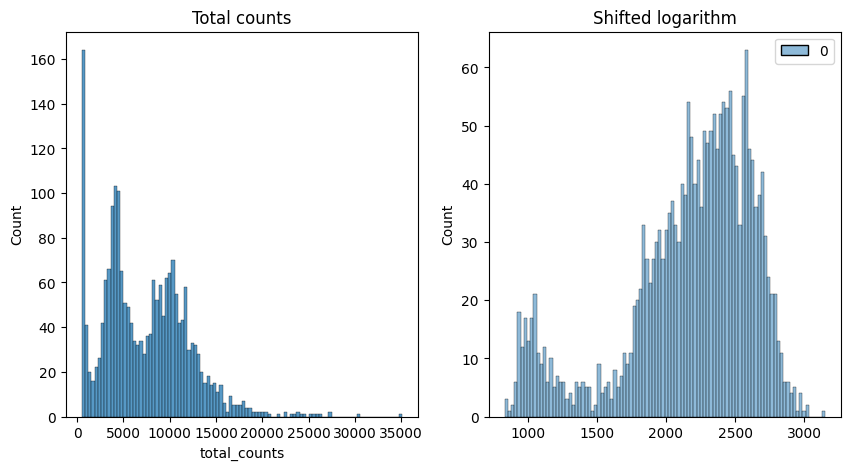

Sample: GC111489_SI-GA-C4
Tissue: Submucosa
normalizing counts per cell
    finished (0:00:00)


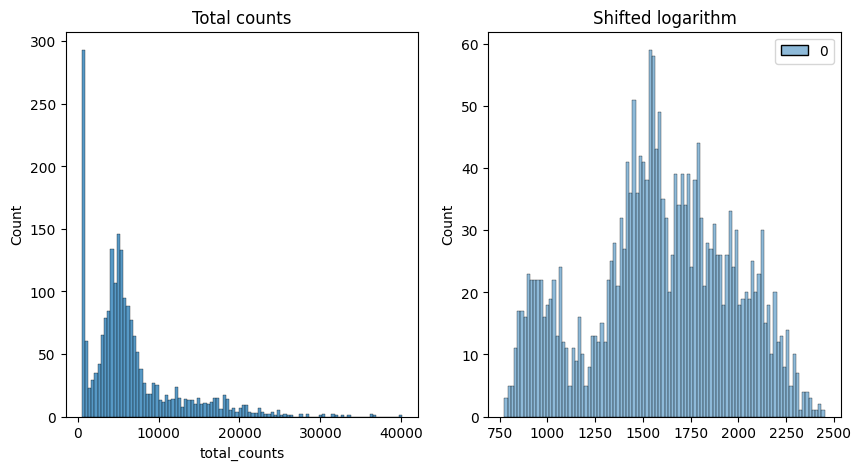

Sample: GC111490_SI-GA-D4
Tissue: Lamina Propria
normalizing counts per cell
    finished (0:00:00)


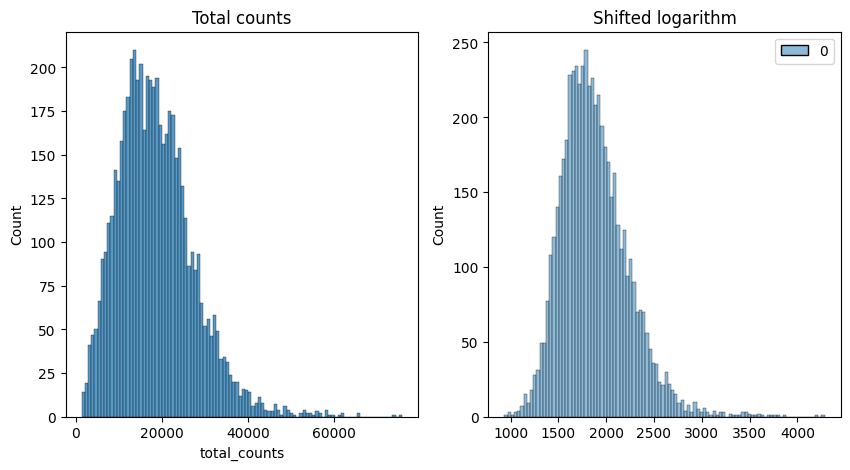

Sample: GC115856_SI-GA-E3
Tissue: Muscularis
normalizing counts per cell
    finished (0:00:00)


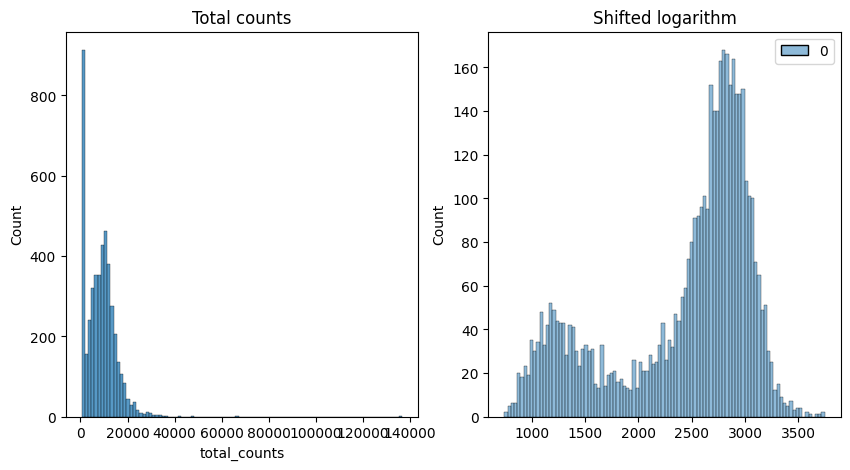

Sample: GC115857_SI-GA-F3
Tissue: Submucosa
normalizing counts per cell
    finished (0:00:00)


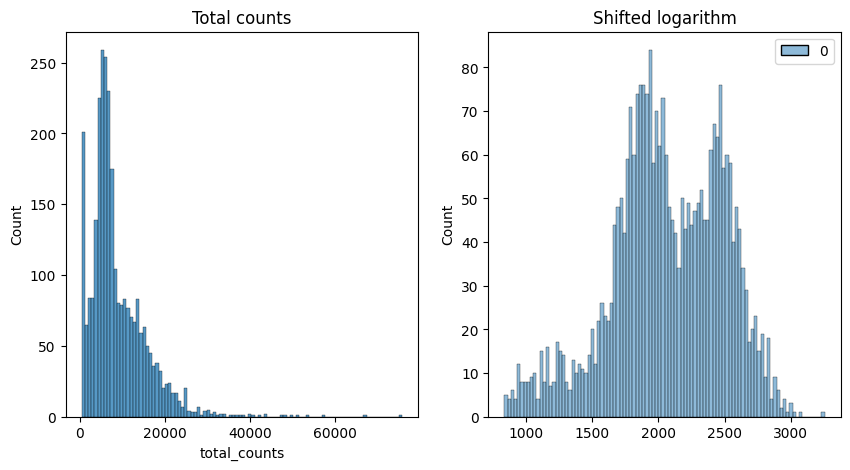

Sample: GC115858_SI-GA-G3
Tissue: Lamina Propria
normalizing counts per cell
    finished (0:00:00)


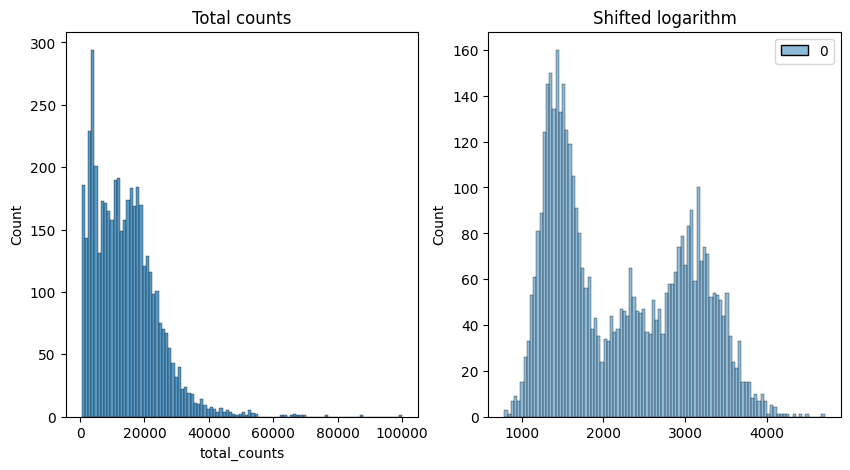

Sample: GC115989_SI-GA-H3
Tissue: Muscularis
normalizing counts per cell
    finished (0:00:00)


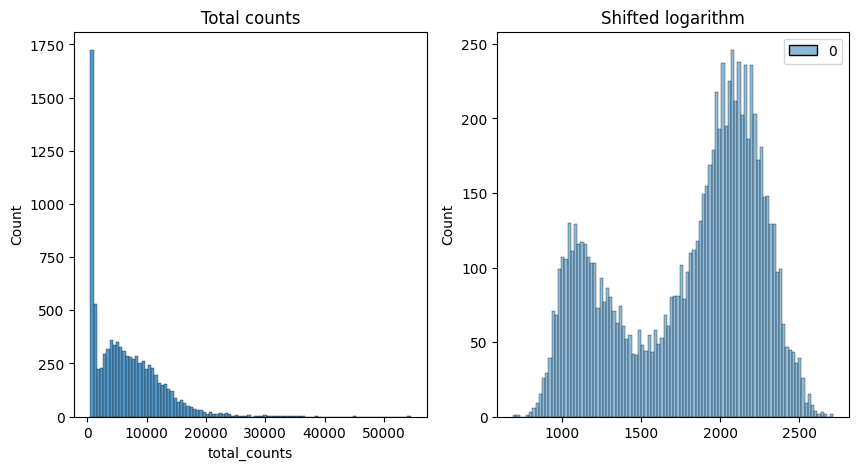

Sample: GC115990_SI-GA-A4
Tissue: Submucosa
normalizing counts per cell
    finished (0:00:00)


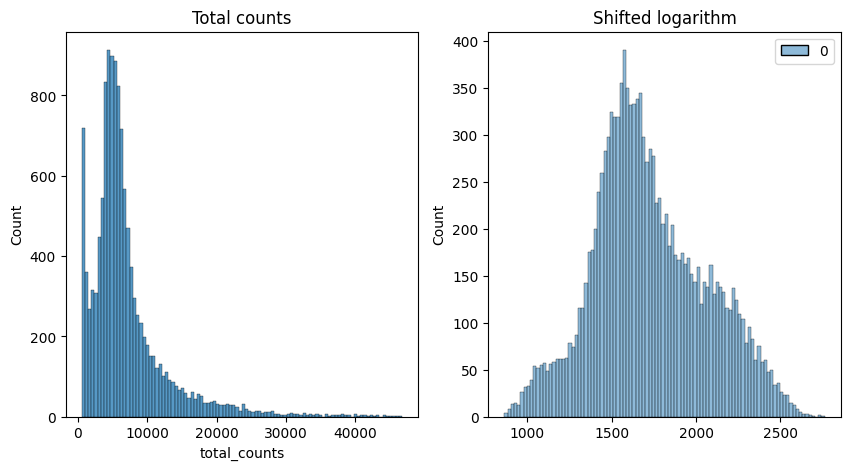

Sample: GC115991_SI-GA-B4
Tissue: Lamina Propria
normalizing counts per cell
    finished (0:00:00)


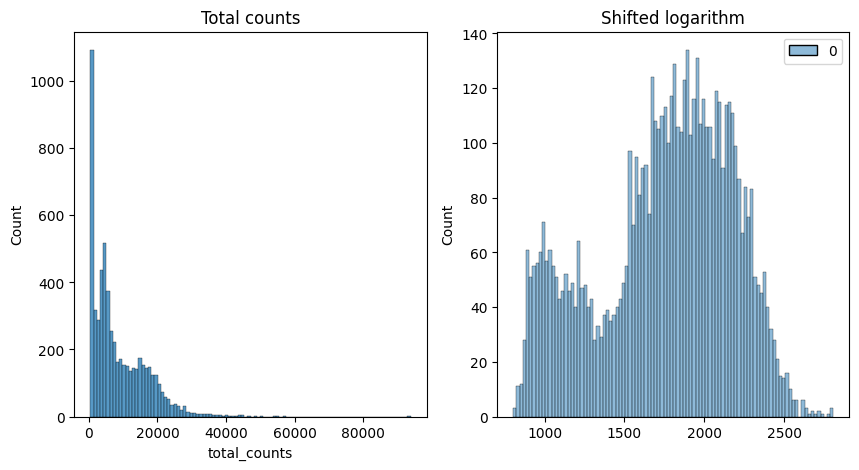

In [22]:
samples=combined.obs["batch"].unique()
norm_adatas=[]
for sample in samples:
    print(f"Sample: {sample}")
    print(f"Tissue: {merged.loc[merged['GC code']==sample,'layer'].values[0]}")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    subset=combined[combined.obs["batch"] ==sample].copy()
    subset=normalize_subset(subset,axes)
    norm_adatas.append(subset)
    fig.suptitle(sample)
    plt.show()

In [29]:
import anndata as ann
combined = ann.concat(norm_adatas, merge="same")
print("After filtering: ",combined.shape[0])
combined.obs_names_make_unique()

After filtering:  126805


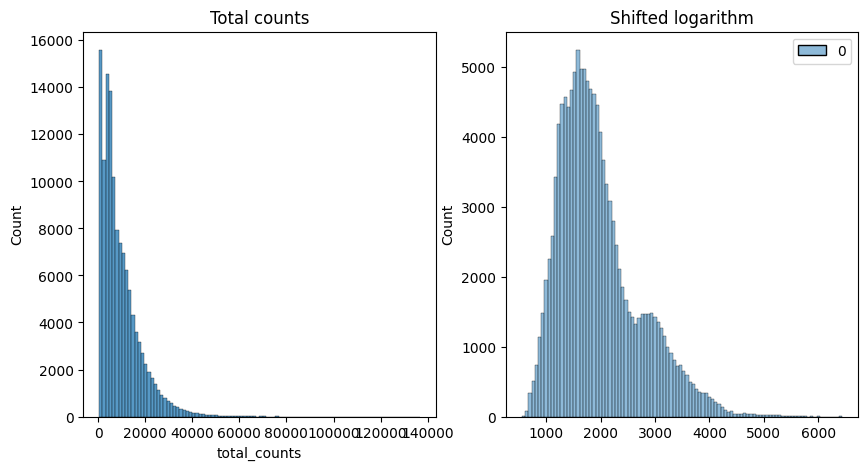

In [30]:
import matplotlib.pyplot as plt
import os
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(combined.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(combined.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()
combined.write(os.path.join("/media/gambino/students_workdir/ibp","combined_normalizedpersample_qced_filtered_counts_13_11.h5"))

normalizing counts per cell
    finished (0:00:00)


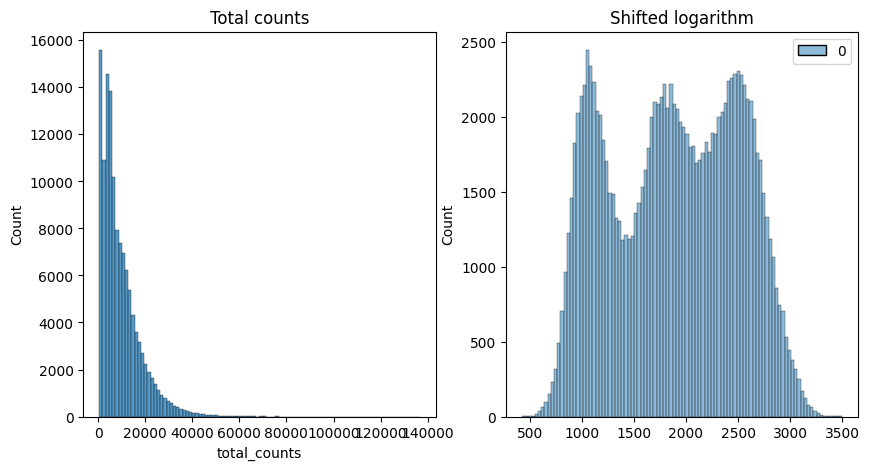

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
combined=normalize_subset(combined,axes)
combined.write(os.path.join("/media/gambino/students_workdir/ibp","combined_normalizedpersampleglobal_qced_filtered_counts_13_11.h5"))